In [1]:
from typing import Any, Callable, NamedTuple, Tuple, Union
Step = int
Schedule = Callable[[Step], float]

from IPython import display
from IPython.display import Image, clear_output
from PIL import Image
import glob, os, shutil

import time

import scipy.io as io
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
import scipy as sp
from scipy.stats import gaussian_kde
from scipy.linalg import null_space

import jax
from jax import jit, vmap, random, grad, hessian
from jax.experimental import optimizers
from jax.experimental.optimizers import optimizer
from jax import numpy as jnp

from functools import partial
import itertools

import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc
import seaborn as sns

import datetime
from tqdm.notebook import tqdm

import networkx as nx

%load_ext autoreload
%autoreload 2

In [2]:
import utils
from utils import *

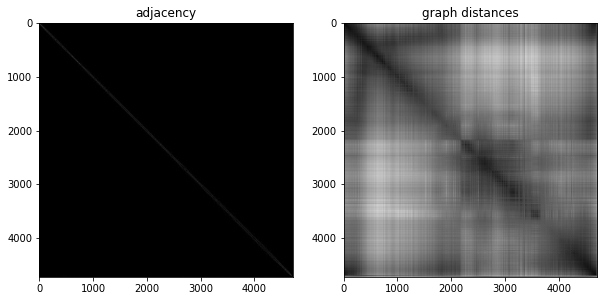

In [3]:
# load the data from the SuiteSparse Matrix Collection format
#   https://www.cise.ufl.edu/research/sparse/matrices/
#graph_name = 'qh882'
#graph_name = 'dwt_1005'
graph_name = '3elt'
mat_data = io.loadmat(graph_name + '.mat')
graph = mat_data['Problem']['A'][0][0]
fig1, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,20))
ax1.imshow(graph.todense()!=0, cmap='gray')
ax1.set_title("adjacency")
graphdist = csgraph.shortest_path(graph, directed=False, unweighted=True)
ax2.set_title("graph distances")
ax2.imshow(graphdist, cmap='gray')

In [4]:
G = nx.from_numpy_matrix(graph.toarray().astype(int)!= 0, create_using=None)
A = nx.adjacency_matrix(G).toarray().astype(np.float32)
L = csgraph_laplacian(A, normed=False)
D = np.diag(np.sum(A, axis=1))
n = L.shape[0]
n

4720

Objective and constraints

$f(x, y) = x^TAx + y^TAy + 2b^Tx + 2d^Ty$ 

$g(x, y) = [v^Tx, v^Ty]$ 

$h(x, y) = [x^TDx - c_1, y^TDy - c_2, 2(x^TDy - c_3)]$

In [5]:
@jit
def f(X, A_x, A_y, b_x, b_y):
    obj= X[:,0].T@A_x@X[:,0] + X[:,1].T@A_y@X[:,1] + 2*b_x.T@X[:,0] + 2*b_y.T@X[:,1]
    return obj.real

@jit
def f_l(X, L, C, A_x, A_y, b_x, b_y):
    obj = jnp.trace(jnp.inner(X, A_x@X + 2*jnp.stack([b_x,b_y],axis=1))) + jnp.trace(jnp.inner(L, X.T@X - C))
    return obj.real

def g(X, v, c):
    return np.array([v.T@X[:,0], v.T@X[:,1]]) - c

def h(X, D, c1, c2, c3, c=jnp.array([0,0])):
    return np.array([(X[:,0]-c[0]).T@D@(X[:,0]-c[0]) - c1, 
                     (X[:,1]-c[1]).T@D@(X[:,1]-c[1]) - c2, 
                     2*((X[:,0]-c[0]).T@D@(X[:,1]-c[1]) - c3)])

def wl(X, A_x, A_y):
    return X[:,0].T@A_x@X[:,0] + X[:,1].T@A_y@X[:,1]

Projection

$X = [X_1]_+ = X_1C_1^{-1/2}UV^TC^{1/2}$

where $C_1 = X_1^TX_1$, $C = X^TX$, and $U\Sigma V^T = C^{1/2}C_1^{1/2}$

In [6]:
@jit
def project(X1, C, c=jnp.array([0,0])):
    C1 = X1.T@X1
    C1sqrt = utils._sqrtm(C1)
    Csqrt = utils._sqrtm(C)
    U,s,V = jnp.linalg.svd(Csqrt@C1sqrt)
    X = X1@jnp.linalg.inv(C1sqrt)@U@V.T@Csqrt
    return X.real

In [7]:
def pgd(X_k, A_x, A_y, b_x, b_y, C, c=jnp.array([0,0])):
    """Perform iterations of PGD, without autograd."""
    loss = []
    param_hist  = []
    for k in tqdm(range(1000)):
        X_k_x = X_k[:,0] - alpha*A_x@X_k[:,0]
        X_k_y = X_k[:,1] - alpha*A_y@X_k[:,1]
        X_k = np.vstack([X_k_x,X_k_y]).T - alpha*np.vstack([b_x,b_y]).T
        X_k = project(X_k, C, c)
        param_hist.append(X_k)
        loss.append(f(X_k, A_x, A_y, b_x, b_y))   
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist}

@jit
def step(i, opt_state, A_x, A_y, b_x, b_y):
    """Perform a single gradient (using autograd) + projection step with adaptive momentum."""
    p = get_params(opt_state)
    g = grad(f)(p, A_x, A_y, b_x, b_y)
    return opt_update(i, g, opt_state)

def pgd_autograd(opt_params, A_x, A_y, b_x, b_y, C, convergence_criterion, maxiters=1000):
    """Perform iterations of PGD, with autograd """
    opt_state, opt_update, get_params = opt_params
    E_0 = np.stack([b_x, b_y], axis=1)
    X_k = get_params(opt_state)
    loss = [np.array(f(X_k, A_x, A_y, b_x, b_y))]
    Lh = [np.eye(2)]
    param_hist  = [X_k]
    grad_hist= []
    hess_hist = []
    for k in tqdm(range(maxiters)):
        opt_state = step(k, opt_state, A_x, A_y, b_x, b_y)
        X_k = get_params(opt_state)
        param_hist.append(X_k)
        l = np.array(f(X_k, A_x, A_y, b_x, b_y))
        
        assert not np.isnan(l)
        
        if len(loss) > 1 and np.abs(l - loss[-1]) <= convergence_criterion:
            break
        loss.append(l)

        L = -jnp.linalg.inv(C)@(X_k.T@(A_x@X_k+E_0))
        Lh.append(L)
        
        gr = grad(f_l)(X_k, L, C, A_x, A_y, b_x, b_y)
        grad_hist.append(np.linalg.norm(gr[:,0]) + np.linalg.norm(gr[:,1]))
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist, 'foc':grad_hist, 'hess':hess_hist, 'L':Lh}

@jit
def _step(i, opt_state, Z):
    """Perform a single descent + projection step with arbitrary descent direction."""
    return opt_update(i, Z, opt_state)

@jit
def sqp(A, L, E_0, X):
    """Compute the newton direction and lagrangian multipliers"""
    I = jnp.eye(A.shape[0])
    w, v = jnp.linalg.eig(L)
    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]

    D = jnp.diag(w)
    E = -E_0 - (A@X + X@L)
    
    Del_0 = jnp.linalg.inv(X.T@jnp.linalg.inv(A + D[0,0]*I)@X)@X.T@jnp.linalg.inv(A + D[0,0]*I)@E[:,0]
    Z_0 = jnp.linalg.inv(A + D[0,0]*I)@(-X@Del_0 + E[:,0])
    
    Del_1 = jnp.linalg.inv(X.T@jnp.linalg.inv(A + D[1,1]*I)@X)@X.T@jnp.linalg.inv(A + D[1,1]*I)@E[:,1]
    Z_1 = jnp.linalg.inv(A + D[1,1]*I)@(-X@Del_1 + E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del

"""Perform iterations of PND + backtracking line search."""
def newton(opt_params, A, L, C, X_k, b_x, b_y, convergence_criterion, 
           maxiters=100, alpha=1e-2, beta=0.9):
    opt_state, opt_update, get_params = opt_params
    loss = [np.array(f(X_k, A, A, b_x, b_y))]
    param_hist  = []
    E_0 = np.stack([b_x, b_y], axis=1)
    X_k, _ = get_params(opt_state)
    
    grad_hist= []
    hess_hist = []
    
    data = {'L':[], 'gradcorr':[], 'stp':[]}
    for k in tqdm(range(maxiters)):  
        Z, Del = sqp(A, L, E_0, X_k)
        
        # backtracking line search
        f_x = f(X_k, A, A, b_x, b_y)
        #f_x = f_l(X_k, L, C, A, A, b_x, b_y)
        f_xp = 1e8
        stp = 1
        
        gr = grad(f)(X_k, A, A, b_x, b_y)
        derphi = np.trace(np.dot(gr.T, Z))
        #derphi = np.trace(np.dot(grad(f_l)(X_k, L, C, A, A, b_x, b_y).T, Z))

        len_p = np.linalg.norm(Z)
        X_k_t = X_k
        
        opt_state_t = opt_state
        
        while f_xp >= f_x: #- alpha * stp * derphi:
            stp *= beta
            opt_state_t = _step(stp, opt_state, (-Z, -Del))
            X_k_t, _ = get_params(opt_state_t)
            
            #L_t = L + stp*Del
            L_t = -jnp.linalg.inv(C)@(X_k_t.T@(A@X_k_t+E_0))
            
            f_xp = np.array(f(X_k_t, A, A, b_x, b_y))
        
            if stp * len_p < 1e-6:
                break       
                
        opt_state = opt_state_t
        X_k, _ = get_params(opt_state_t)
        L = L_t.real
        param_hist.append(X_k)
        gr = grad(f_l)(X_k, L, C, A, A, b_x, b_y)
        grad_hist.append(np.linalg.norm(gr[:,0]) + np.linalg.norm(gr[:,1]))
        
        
        if len(loss) > 1 and np.abs(f_xp - loss[-1]) <= convergence_criterion:
            break
        loss.append(np.array(f(X_k, A, A, b_x, b_y)))
        data['gradcorr'].append(derphi)
        data['L'].append(L)
        data['stp'].append(stp)
        
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist, 'ext_data':data, 'foc':grad_hist}
    
def ssm():
    """
    1. compute newton direction z = sqp(X, Z, v, Ax + E0) & subspace S
    2. approximate locally optimal X, L on S; X = min F(\hat{X}, B, V.T@E0)
    """
    pass

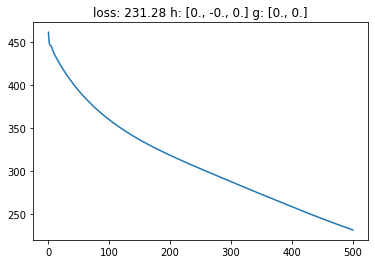

In [8]:
def cluster(rng, opt_params, X_k, A, fixed_indices, maxiters=1000, convergence_criterion=1e-3,
            c1=1, c2=1, c3=0, centroid=jnp.array([0,0]), centercons=None, v=None, D=None, eps=1e-8, method='pgd'):
    """Given an adjacency matrix A and initialization X_k, optimize X."""
    method = method.lower()
    assert method in ['pgd','pnd','ssm']
    assert len(A.shape) == 2
    assert A.shape[0] == X_k.shape[0]
    
    k = fixed_indices.shape[0]
    fixed_coordsx = X_k[fixed_indices,0]
    fixed_coordsy = X_k[fixed_indices,1]
    A0 = A

    N = A.shape[0]

    if v is None:
        v = jnp.ones(N)
    if D is None:
        D = jnp.diag(v)
    if centercons is None:
        centercons = jnp.zeros(2)

    fixed_idx = np.zeros((k,N))
    for i in range(k):
        fixed_idx[i,fixed_indices[i]] += 1
        
    if k>0:
        constraints = np.concatenate([fixed_idx,np.expand_dims(1-fixed_idx.sum(0),0)])
        fixed_coordsx = np.concatenate([fixed_coordsx,np.expand_dims(centercons[0],0)])
        fixed_coordsy = np.concatenate([fixed_coordsy,np.expand_dims(centercons[1],0)])
        P = null_space(constraints).T
        
        n0_x = np.linalg.pinv(constraints)@fixed_coordsx
        b_x = P@A@n0_x
        
        n0_y = np.linalg.pinv(constraints)@fixed_coordsy
        b_y = P@A@n0_y
        
        A = P@A@P.T
    else:
        constraints = np.expand_dims(np.ones(n),0)    
        P = null_space(constraints).T

        n0_x = np.linalg.pinv(constraints)@(np.expand_dims(centercons[0],0))
        b_x = P@A@n0_x

        n0_y = np.linalg.pinv(constraints)@(np.expand_dims(centercons[1],0))
        b_y = P@A@n0_y
         
        A = P@A@P.T
        
    C = jnp.block([[c1, c3],[c3, c2]])

    assert np.linalg.det(C) > 1e-5  
    
    n0 = np.stack([n0_x,n0_y],axis=0)
    X_k_n = np.array(np.linalg.pinv(P.T)@(X_k-n0.T))
    X_k_n = project(X_k_n, C, centercons)
    L = np.eye(2)
    
    if method == "pgd":
        opt_init, opt_update, get_params = padam(5e-1,partial(lambda x, y, z: project(z, x, y), C, centroid), 
                                             b1=0.9, b2=0.999, eps=1e-08)
        opt_init, opt_update, get_params = opt_params
        opt_state = opt_init(X_k_n)
        A_x = A
        A_y = A
        result = pgd_autograd((opt_state, opt_update, get_params), A_x, A_y, b_x, b_y, C, 
                              convergence_criterion=convergence_criterion, maxiters=maxiters)        
    elif method == "pnd":
        opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))
        opt_init, opt_update, get_params = opt_params
        opt_state = opt_init((X_k_n, L))
        result = newton((opt_state, opt_update, get_params), A, L, C, X_k_n, b_x, b_y, 
                        convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.5, beta=0.9)        
    else:
        print("method not supported")
        return 1

    #X_k = result['x']
    X_k = result['sln_path'][np.argmin(result['lossh'])]
    X_k = project(X_k, C, centroid)
    X_k_n = np.zeros((N,2))
    X_k_n[:,0] = np.array(P.T@X_k[:,0]) + n0_x.T
    X_k_n[:,1] = np.array(P.T@X_k[:,1]) + n0_y.T
        
    result['x'] = X_k_n
    
    mask = (1-fixed_idx.sum(0)).astype(np.bool)
    result['mask'] = mask
    result['centroid'] = centercons
    if fixed_idx.sum() == 0:
        result['g'] = g(X_k_n, v, centercons)
        result['h'] = h(X_k_n, np.diag(v), c1, c2, c3, centroid)        
    else:
        result['g'] = g(X_k_n[mask], v[mask], centercons)
        result['h'] = h(X_k_n[mask], np.diag(v[mask]), c1, c2, c3, centroid)
        #result['h'] = h(X_k, np.diag(np.ones(X_k.shape[0])), c1, c2, c3, centroid)
    result['P'] = (P)
    result['e'] = np.vstack([b_x,b_y])
    result['n'] = (n0_x, n0_y)
    
    result['wirelength'] = wl(X_k_n, A0, A0)

    return result

method = "pgd" # pnd or pgd
seed = 0
rng = random.PRNGKey(seed)

v = np.ones(n)
c1=v.sum()*10**2*1/12
c2=v.sum()*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

if method == "pgd":
    # 5e-2
    opt_init, opt_update, get_params = padam(1e-2,partial(lambda x, y: project(y,x),C), b1=0.9, b2=0.999, eps=1e-08)
elif method == "pnd":
    opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))

eps = 1e-8
alpha = 5e-3
key, subkey = jax.random.split(rng)

# initialization
X_k_r = random.normal(subkey, (n,2))*np.sqrt(10)

#w,v = np.linalg.eig(L)
w,v = sp.sparse.linalg.eigsh(L, k=5, which='SM')
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
X_k = v[:,-3:-1]

fixed_indices = np.array([1,2,3,4,5,6,7,8,9,10])
X_k[fixed_indices] = X_k_r[fixed_indices]

result = cluster(rng, (opt_init, opt_update, get_params), 
                 X_k, L, fixed_indices=fixed_indices,c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), 
                 v=None, D=None, eps=1e-8, maxiters=500, convergence_criterion=1e-5, method=method)
results = [result]

X_k_n=result['x']
loss = result['lossh']
param_hist = result['sln_path']

gc = result['g']
hc = result['h']
plt.plot(loss)
#plt.title('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))
plt.title('loss: {} h: [0., -0., 0.] g: [0., 0.]'.format(str(np.round(loss[-1],2))))
plt.show()

Text(0.5, 1.0, 'initial foc: 68.151, final foc: 26.068')

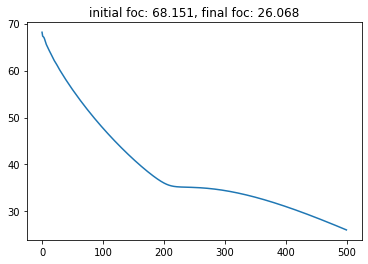

In [10]:
plt.plot(result['foc'])
plt.title('initial foc: {:.3f}, final foc: {:.3f}'.format(result['foc'][0], result['foc'][-1]))

In [12]:
np.linalg.eig(result['ext_data']['L'][-1])[0], np.sort(np.linalg.eig(result['P']@L@result['P'].T)[0])[:6]

(array([-0.00609223, -0.00281984], dtype=float32),
 array([0.00232606, 0.00564505, 0.00739835, 0.0093147 , 0.01091754,
        0.01305648]))

In [45]:
pap = result['P']@L@result['P'].T

1.0 - ( np.count_nonzero(pap) / float(pap.size) ), 1.0 - ( np.count_nonzero(L) / float(L.size) )

(0.0, 0.9985562697500718)

In [21]:
np.linalg.eigvals(result['ext_data']['L'][-1] + 0.07721325*np.eye(2))

array([0.0339752, 0.046626 ], dtype=float32)

In [13]:
size = np.array([5, 5])
voxel_id, voxel2bound = voxel_cluster(X_k_n, size)

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


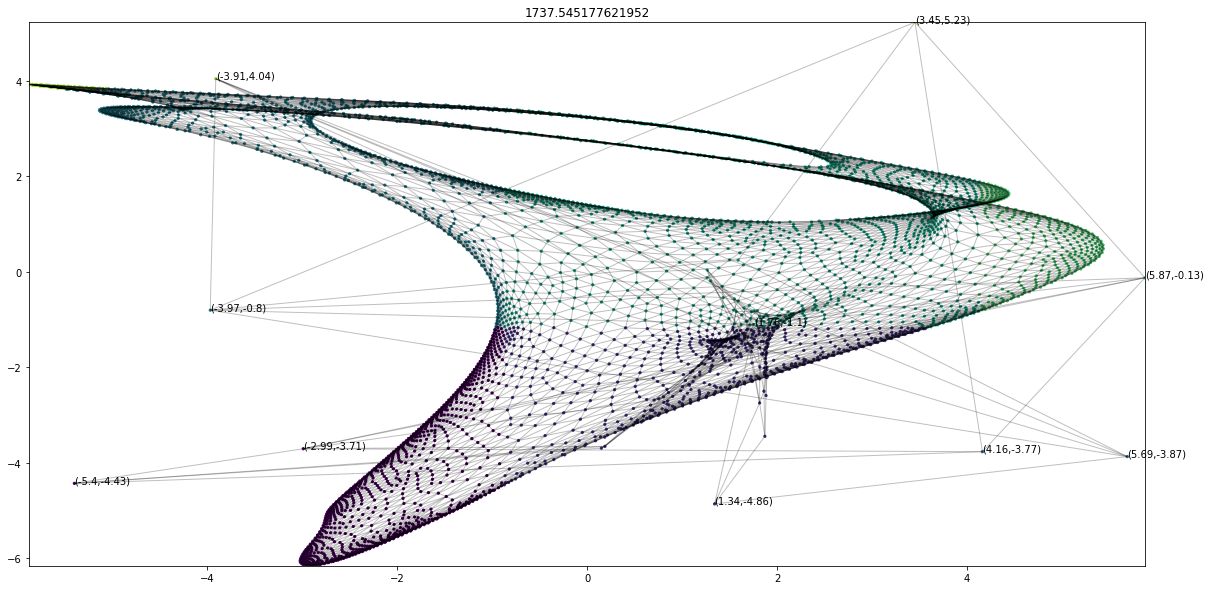

In [14]:
utils.plot_graph(X_k_n, graph, title=result['wirelength'], fixed_indices=fixed_indices, c=voxel_id)

In [10]:
"""
WORK IN PROGRESS BELOW 
"""

'\nWORK IN PROGRESS BELOW \n'

In [11]:
#tst = np.random.uniform(-5,5,(10000,2))
#size = np.array([5, 5])
#voxel_id, voxel2bound = voxel_cluster(tst, size)
#plt.scatter(tst[:,0], tst[:,1], c=voxel_id)
#plt.colorbar()
#np.unique(voxel_id, return_index=True)[0]

In [12]:
#unique_voxels, num_voxels_per_row

In [17]:
"""
yo
"""

X_k = X_k_n
width = 10
size = np.array([width/2, width/2])

# levels
for _ in tqdm(range(2)): 
    size = size/2
    voxel_id, voxel2bound = voxel_cluster(X_k, size)
    unique_voxels, unique_vidx = np.unique(voxel_id, return_index=True)
    
    num_voxels_per_row = width/size[0]
    num_voxels=num_voxels_per_row**2
    
    for _ in range(5):
        np.random.shuffle(unique_vidx)
        
        for vidx in unique_vidx:
            vid = voxel_id[vidx]
            fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)
            #fixed_indices = (~np.sum([clust_to_mask(voxel_id, vid), 
            #                          clust_to_mask(voxel_id, min(vid+1, num_voxels_per_row//(vid+1)*num_voxels_per_row))], axis=0).astype(bool)).astype(int) 
            #fixed_indices = (~np.sum([clust_to_mask(voxel_id, vid), 
            #                          clust_to_mask(voxel_id, min(vid+1, num_voxels_per_row//(vid+1)*num_voxels_per_row)),
            #                          clust_to_mask(voxel_id, min(vid+num_voxels_per_row, num_voxels)), 
            #                          clust_to_mask(voxel_id, min(vid+num_voxels_per_row+1, num_voxels))], axis=0).astype(bool)).astype(int) 

            if (1-fixed_indices).sum() < 4:
                continue

            num_move = (1-fixed_indices).sum()
            cc1 = num_move*size[0]**2*1/12
            cc2 = num_move*size[1]**2*1/12
            #cc1 = num_move*(2*size[0])**2*1/12
            #cc2 = num_move*(2*size[1])**2*1/12
            cc3 = 0

            C = jnp.block([[cc1, cc3],[cc3, cc2]])

            offset = (np.max(X_k,axis=0) - np.min(X_k,axis=0))/2
            centroid = voxel2bound[vidx]*size + size/2 - offset
            #centroid = jax.ops.index_add(centroid, 0, size[0]/2)
            #centroid = voxel2bound[vidx]*size - offset
            #centroid = np.mean(X_k[(1-fixed_indices)],axis=0)

            method = "pgd"
            if method == "pgd":
                opt_init, opt_update, get_params = padam(1e-2, partial(lambda x, y: project(y,x),C), 
                                                         b1=0.9, b2=0.999, eps=1e-08)
            elif method == "pnd":
                opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))


            result = cluster(rng, (opt_init, opt_update, get_params), 
                             X_k, L, np.where(fixed_indices)[0], maxiters=1000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                             centercons=num_move*centroid, v=None, D=None, eps=1e-8, 
                             convergence_criterion=1e-3, method=method)

            results.append(result)
            X_k = result['x']
            gc = result['g']
            hc = result['h']
            loss = result['lossh']
            #param_hist.extend(result['sln_path'])
            print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))   



loss: -38.68 h: [ 0.  0. -0.] g: [0. 0.]



loss: 4.48 h: [ 0.  0. -0.] g: [0. 0.]



loss: 12.3 h: [ 0.  0. -0.] g: [0. 0.]



loss: -0.66 h: [0. 0. 0.] g: [0. 0.]



loss: -7.22 h: [-0. -0. -0.] g: [0. 0.]



loss: 23.36 h: [-0. -0. -0.] g: [0. 0.]



loss: -40.96 h: [-0. -0. -0.] g: [0. 0.]



loss: 3.8 h: [ 0.  0. -0.] g: [0. 0.]



loss: -53.73 h: [-0.  0. -0.] g: [0. 0.]



loss: -31.05 h: [ 0. -0.  0.] g: [0. 0.]



loss: 22.91 h: [-0.  0.  0.] g: [0. 0.]



loss: 3.93 h: [ 0.  0. -0.] g: [0. 0.]



loss: -60.65 h: [ 0.  0. -0.] g: [0. 0.]



loss: -3.2 h: [0. 0. 0.] g: [0. 0.]



loss: -30.67 h: [ 0.  0. -0.] g: [0. 0.]



loss: -18.59 h: [ 0. -0.  0.] g: [0. 0.]



loss: 1.59 h: [0. 0. 0.] g: [0. 0.]



loss: -120.22 h: [-0. -0.  0.] g: [0. 0.]



loss: 10.95 h: [-0. -0.  0.] g: [0. 0.]



loss: -20.8 h: [ 0.  0. -0.] g: [0. 0.]



loss: 24.03 h: [0. 0. 0.] g: [0. 0.]



loss: -106.3 h: [0. 0. 0.] g: [0. 0.]



loss: -4.81 h: [-0.  0. -0.] g: [0. 0.]



loss: -19.78 h: [0. 0. 0.] g: [0. 0.]



loss: 0.36 h: [-0. -0.  0.] g: [0. 0.]



loss: 7.33 h: [ 0. -0. -0.] g: [0. 0.]



loss: -44.45 h: [0. 0. 0.] g: [0. 0.]



loss: -32.48 h: [ 0. -0.  0.] g: [0. 0.]



loss: -21.87 h: [-0. -0.  0.] g: [0. 0.]



loss: -4.42 h: [-0.  0. -0.] g: [0. 0.]



loss: 17.99 h: [ 0.  0. -0.] g: [0. 0.]



loss: -43.06 h: [ 0.  0. -0.] g: [0. 0.]



loss: -20.49 h: [ 0. -0.  0.] g: [0. 0.]



loss: 5.94 h: [0. 0. 0.] g: [0. 0.]



loss: 1.09 h: [-0.  0. -0.] g: [0. 0.]



loss: -5.06 h: [0. 0. 0.] g: [0. 0.]



loss: -107.48 h: [0. 0. 0.] g: [0. 0.]



loss: -5.05 h: [ 0.  0. -0.] g: [0. 0.]



loss: -31.87 h: [0. 0. 0.] g: [0. 0.]



loss: -15.23 h: [ 0. -0.  0.] g: [0. 0.]



loss: -0.09 h: [0. 0. 0.] g: [0. 0.]



loss: -43.63 h: [ 0. -0.  0.] g: [0. 0.]



loss: -24.08 h: [ 0.  0. -0.] g: [0. 0.]



loss: -5.26 h: [0. 0. 0.] g: [0. 0.]



loss: -32.06 h: [0. 0. 0.] g: [0. 0.]



loss: -13.63 h: [ 0. -0.  0.] g: [0. 0.]



loss: -5.13 h: [-0. -0. -0.] g: [0. 0.]



loss: 5.74 h: [-0.  0.  0.] g: [0. 0.]



loss: -92.37 h: [ 0. -0.  0.] g: [0. 0.]



loss: 21.08 h: [-0. -0. -0.] g: [0. 0.]



loss: 36.54 h: [14.84 14.84  0.  ] g: [0. 0.]



loss: -0.55 h: [-0. -0. -0.] g: [0. 0.]



loss: 6.24 h: [ 0. -0. -0.] g: [0. 0.]



loss: 0.72 h: [0. 0. 0.] g: [0. 0.]



loss: -2.81 h: [0. 0. 0.] g: [0. 0.]



loss: 13.46 h: [10.16 10.16  0.  ] g: [0. 0.]



loss: -4.23 h: [ 0. -0.  0.] g: [0. 0.]



loss: 40.58 h: [13.28 13.28 -0.  ] g: [0. 0.]



loss: -0.15 h: [ 0. -0.  0.] g: [0. 0.]



loss: -3.59 h: [ 0.  0. -0.] g: [0. 0.]



loss: -1.84 h: [ 0.  0. -0.] g: [0. 0.]



loss: -2.83 h: [ 0.  0. -0.] g: [0. 0.]



loss: -2.81 h: [-0. -0.  0.] g: [0. 0.]



loss: 1.66 h: [-0.  0.  0.] g: [0. 0.]



loss: 15.24 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: 2.67 h: [-0.  0.  0.] g: [0. 0.]



loss: 1.78 h: [ 0. -0. -0.] g: [0. 0.]



loss: 1.08 h: [-0. -0. -0.] g: [0. 0.]



loss: 1.8 h: [0. 0. 0.] g: [0. 0.]



loss: -5.29 h: [0. 0. 0.] g: [0. 0.]



loss: -0.5 h: [-0.  0.  0.] g: [0. 0.]



loss: 35.21 h: [10.16 10.16 -0.  ] g: [0. 0.]



loss: 1.46 h: [ 0.  0. -0.] g: [0. 0.]



loss: 40.62 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: -1.14 h: [ 0. -0.  0.] g: [0. 0.]



loss: -3.12 h: [ 0.  0. -0.] g: [0. 0.]



loss: 0.08 h: [-0. -0.  0.] g: [0. 0.]



loss: 22.63 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: 0.23 h: [ 0. -0.  0.] g: [0. 0.]



loss: -1.33 h: [ 0. -0. -0.] g: [0. 0.]



loss: 5.08 h: [ 0. -0. -0.] g: [0. 0.]



loss: -0.66 h: [ 0.  0. -0.] g: [0. 0.]



loss: -32.0 h: [-0.  0. -0.] g: [0. 0.]



loss: -1.77 h: [ 0. -0.  0.] g: [0. 0.]



loss: -21.16 h: [-0.  0. -0.] g: [0. 0.]



loss: 3.28 h: [0. 0. 0.] g: [0. 0.]



loss: 8.1 h: [2.34 2.34 0.  ] g: [0. 0.]



loss: 2.56 h: [ 0.  0. -0.] g: [0. 0.]



loss: -10.02 h: [ 0.  0. -0.] g: [0. 0.]



loss: 1.79 h: [ 0. -0.  0.] g: [0. 0.]



loss: -15.0 h: [ 0.  0. -0.] g: [0. 0.]



loss: -1.31 h: [0. 0. 0.] g: [0. 0.]



loss: -1.05 h: [ 0.  0. -0.] g: [0. 0.]



loss: -0.11 h: [-0.  0. -0.] g: [0. 0.]



loss: 0.61 h: [ 0.  0. -0.] g: [0. 0.]



loss: 8.51 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: -3.31 h: [ 0.  0. -0.] g: [0. 0.]



loss: -3.81 h: [-0.  0.  0.] g: [0. 0.]



loss: -4.26 h: [ 0. -0. -0.] g: [0. 0.]



loss: -4.09 h: [ 0. -0. -0.] g: [0. 0.]



loss: 1.58 h: [-0. -0. -0.] g: [0. 0.]



loss: 3.11 h: [-0. -0. -0.] g: [0. 0.]



loss: -3.94 h: [10.16 10.16  0.  ] g: [0. 0.]



loss: 16.89 h: [14.84 14.84  0.  ] g: [0. 0.]



loss: 62.98 h: [13.28 13.28  0.  ] g: [0. 0.]



loss: -1.69 h: [ 0.  0. -0.] g: [0. 0.]



loss: 4.18 h: [-0.  0. -0.] g: [0. 0.]



loss: 35.82 h: [10.16 10.16 -0.  ] g: [0. 0.]



loss: -19.69 h: [-0.  0.  0.] g: [0. 0.]



loss: -36.68 h: [ 0.  0. -0.] g: [0. 0.]



loss: 5.17 h: [-0.  0.  0.] g: [0. 0.]



loss: 1.02 h: [-0. -0. -0.] g: [0. 0.]



loss: -0.75 h: [ 0.  0. -0.] g: [0. 0.]



loss: 1.22 h: [-0. -0. -0.] g: [0. 0.]



loss: 3.71 h: [-0.  0.  0.] g: [0. 0.]



loss: -5.42 h: [0. 0. 0.] g: [0. 0.]



loss: -1.08 h: [-0. -0. -0.] g: [0. 0.]



loss: 22.02 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: -2.64 h: [ 0.  0. -0.] g: [0. 0.]



loss: -0.63 h: [-0. -0.  0.] g: [0. 0.]



loss: 26.66 h: [2.34 2.34 0.  ] g: [0. 0.]



loss: 14.39 h: [2.34 2.34 0.  ] g: [0. 0.]



loss: 3.16 h: [ 0. -0. -0.] g: [0. 0.]



loss: -5.46 h: [-0.  0.  0.] g: [0. 0.]



loss: -9.46 h: [-0.  0. -0.] g: [0. 0.]



loss: -2.5 h: [0. 0. 0.] g: [0. 0.]



loss: 36.31 h: [10.16 10.16  0.  ] g: [0. 0.]



loss: -4.05 h: [-0.  0. -0.] g: [0. 0.]



loss: -6.22 h: [-0. -0.  0.] g: [0. 0.]



loss: 22.74 h: [2.34 2.34 0.  ] g: [0. 0.]



loss: -0.06 h: [ 0. -0. -0.] g: [0. 0.]



loss: 3.16 h: [-0.  0. -0.] g: [0. 0.]



loss: 1.59 h: [0. 0. 0.] g: [0. 0.]



loss: 16.74 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: 2.0 h: [10.16 10.16 -0.  ] g: [0. 0.]



loss: 0.15 h: [ 0.  0. -0.] g: [0. 0.]



loss: -4.75 h: [-0. -0.  0.] g: [0. 0.]



loss: -0.6 h: [0. 0. 0.] g: [0. 0.]



loss: -0.06 h: [ 0. -0.  0.] g: [0. 0.]



loss: 17.27 h: [14.84 14.84 -0.  ] g: [0. 0.]



loss: -10.42 h: [0. 0. 0.] g: [0. 0.]



loss: -12.36 h: [0. 0. 0.] g: [0. 0.]



loss: 61.58 h: [13.28 13.28 -0.  ] g: [0. 0.]



loss: 3.48 h: [-0. -0.  0.] g: [0. 0.]



loss: 0.63 h: [ 0.  0. -0.] g: [0. 0.]



loss: -4.36 h: [ 0.  0. -0.] g: [0. 0.]



loss: -29.52 h: [-0. -0.  0.] g: [0. 0.]



loss: -2.03 h: [ 0. -0. -0.] g: [0. 0.]



loss: 1.06 h: [ 0. -0. -0.] g: [0. 0.]



loss: -4.75 h: [-0. -0.  0.] g: [0. 0.]



loss: -6.08 h: [-0.  0. -0.] g: [0. 0.]



loss: 16.41 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: -4.73 h: [-0. -0. -0.] g: [0. 0.]



loss: -1.22 h: [ 0. -0. -0.] g: [0. 0.]



loss: 0.4 h: [ 0. -0.  0.] g: [0. 0.]



loss: 1.09 h: [0. 0. 0.] g: [0. 0.]



loss: 5.93 h: [-0. -0.  0.] g: [0. 0.]



loss: 8.31 h: [0. 0. 0.] g: [0. 0.]



loss: -8.23 h: [ 0.  0. -0.] g: [0. 0.]



loss: -0.71 h: [-0.  0. -0.] g: [0. 0.]



loss: 8.21 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: -13.01 h: [0. 0. 0.] g: [0. 0.]



loss: 0.03 h: [0. 0. 0.] g: [0. 0.]



loss: 17.9 h: [2.34 2.34 0.  ] g: [0. 0.]



loss: -1.57 h: [ 0. -0.  0.] g: [0. 0.]



loss: 0.37 h: [0. 0. 0.] g: [0. 0.]



loss: -7.14 h: [-0. -0.  0.] g: [0. 0.]



loss: 0.25 h: [0. 0. 0.] g: [0. 0.]



loss: -6.21 h: [ 0. -0.  0.] g: [0. 0.]



loss: 21.5 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: -4.9 h: [-0.  0.  0.] g: [0. 0.]



loss: 3.77 h: [ 0. -0.  0.] g: [0. 0.]



loss: -2.28 h: [ 0.  0. -0.] g: [0. 0.]



loss: 0.43 h: [0. 0. 0.] g: [0. 0.]



loss: 1.66 h: [-0. -0. -0.] g: [0. 0.]



loss: -12.77 h: [ 0. -0. -0.] g: [0. 0.]



loss: -1.15 h: [-0. -0. -0.] g: [0. 0.]



loss: 53.78 h: [13.28 13.28 -0.  ] g: [0. 0.]



loss: 1.44 h: [10.16 10.16  0.  ] g: [0. 0.]



loss: -6.14 h: [ 0.  0. -0.] g: [0. 0.]



loss: 5.19 h: [-0. -0.  0.] g: [0. 0.]



loss: -0.39 h: [-0.  0. -0.] g: [0. 0.]



loss: -0.75 h: [ 0. -0. -0.] g: [0. 0.]



loss: 2.49 h: [ 0. -0.  0.] g: [0. 0.]



loss: 1.61 h: [-0.  0. -0.] g: [0. 0.]



loss: -1.53 h: [ 0.  0. -0.] g: [0. 0.]



loss: -3.43 h: [0. 0. 0.] g: [0. 0.]



loss: -6.58 h: [0. 0. 0.] g: [0. 0.]



loss: 16.47 h: [14.84 14.84  0.  ] g: [0. 0.]



loss: 35.78 h: [10.16 10.16 -0.  ] g: [0. 0.]



loss: -5.68 h: [-0.  0. -0.] g: [0. 0.]



loss: 16.49 h: [2.34 2.34 0.  ] g: [0. 0.]



loss: 0.59 h: [ 0. -0.  0.] g: [0. 0.]



loss: -4.54 h: [ 0.  0. -0.] g: [0. 0.]



loss: -27.92 h: [ 0. -0. -0.] g: [0. 0.]



loss: -2.38 h: [ 0.  0. -0.] g: [0. 0.]



loss: 5.96 h: [ 0.  0. -0.] g: [0. 0.]



loss: 8.2 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: -3.35 h: [0. 0. 0.] g: [0. 0.]



loss: 8.21 h: [2.34 2.34 0.  ] g: [0. 0.]



loss: -5.92 h: [-0.  0.  0.] g: [0. 0.]



loss: 16.37 h: [14.84 14.84 -0.  ] g: [0. 0.]



loss: 1.62 h: [10.16 10.16 -0.  ] g: [0. 0.]



loss: 5.37 h: [0. 0. 0.] g: [0. 0.]



loss: 4.55 h: [-0.  0.  0.] g: [0. 0.]



loss: -7.45 h: [ 0. -0.  0.] g: [0. 0.]



loss: -2.0 h: [ 0. -0. -0.] g: [0. 0.]



loss: 54.57 h: [13.28 13.28  0.  ] g: [0. 0.]



loss: -1.46 h: [ 0. -0.  0.] g: [0. 0.]



loss: -27.77 h: [0. 0. 0.] g: [0. 0.]



loss: 20.98 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: -5.24 h: [ 0. -0.  0.] g: [0. 0.]



loss: -4.54 h: [0. 0. 0.] g: [0. 0.]



loss: 0.66 h: [ 0.  0. -0.] g: [0. 0.]



loss: 16.41 h: [ 2.34  2.34 -0.  ] g: [0. 0.]



loss: 1.48 h: [ 0.  0. -0.] g: [0. 0.]



loss: -0.78 h: [ 0. -0.  0.] g: [0. 0.]



loss: 0.46 h: [ 0. -0. -0.] g: [0. 0.]



loss: -5.99 h: [ 0. -0.  0.] g: [0. 0.]



loss: -2.25 h: [-0. -0.  0.] g: [0. 0.]



loss: -1.14 h: [-0.  0. -0.] g: [0. 0.]



loss: -12.88 h: [ 0.  0. -0.] g: [0. 0.]



loss: 3.95 h: [-0.  0. -0.] g: [0. 0.]



loss: 0.36 h: [ 0. -0.  0.] g: [0. 0.]



loss: -1.77 h: [-0. -0.  0.] g: [0. 0.]



loss: 1.52 h: [ 0. -0.  0.] g: [0. 0.]



loss: -0.35 h: [-0. -0.  0.] g: [0. 0.]



loss: -4.94 h: [-0. -0. -0.] g: [0. 0.]



loss: 15.1 h: [2.34 2.34 0.  ] g: [0. 0.]



loss: -0.28 h: [ 0. -0.  0.] g: [0. 0.]



loss: 0.93 h: [ 0. -0. -0.] g: [0. 0.]



loss: -6.75 h: [ 0.  0. -0.] g: [0. 0.]



loss: 2.56 h: [0. 0. 0.] g: [0. 0.]



loss: -12.68 h: [ 0.  0. -0.] g: [0. 0.]



loss: 35.27 h: [10.16 10.16  0.  ] g: [0. 0.]



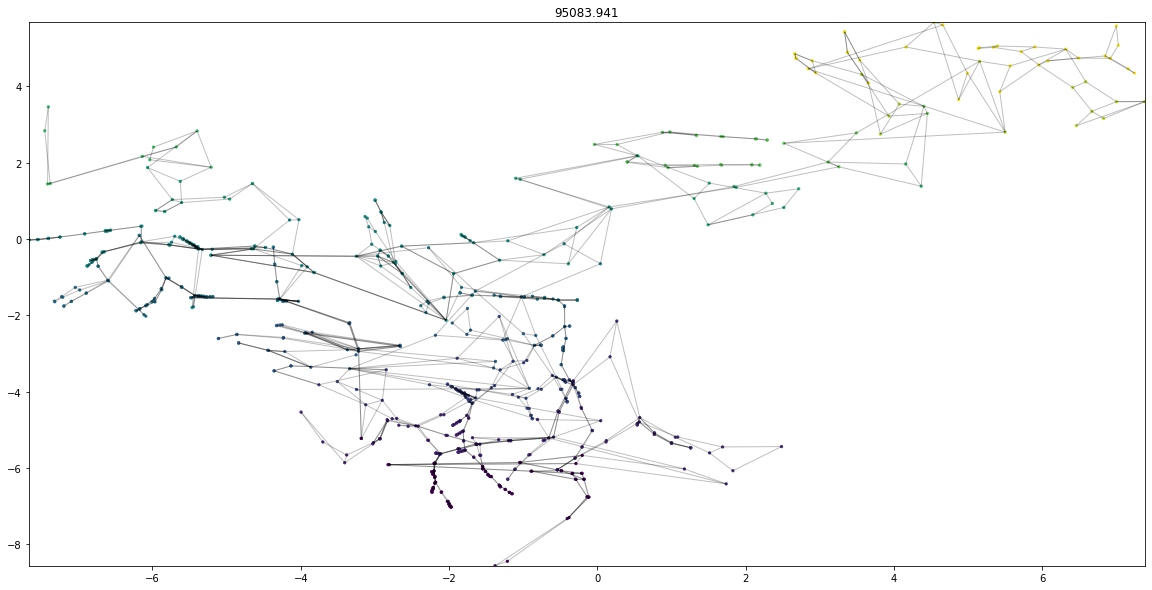

In [18]:
utils.plot_graph(X_k, graph, c=voxel_id,title=str(np.round(wl(X_k, A, A),3)))

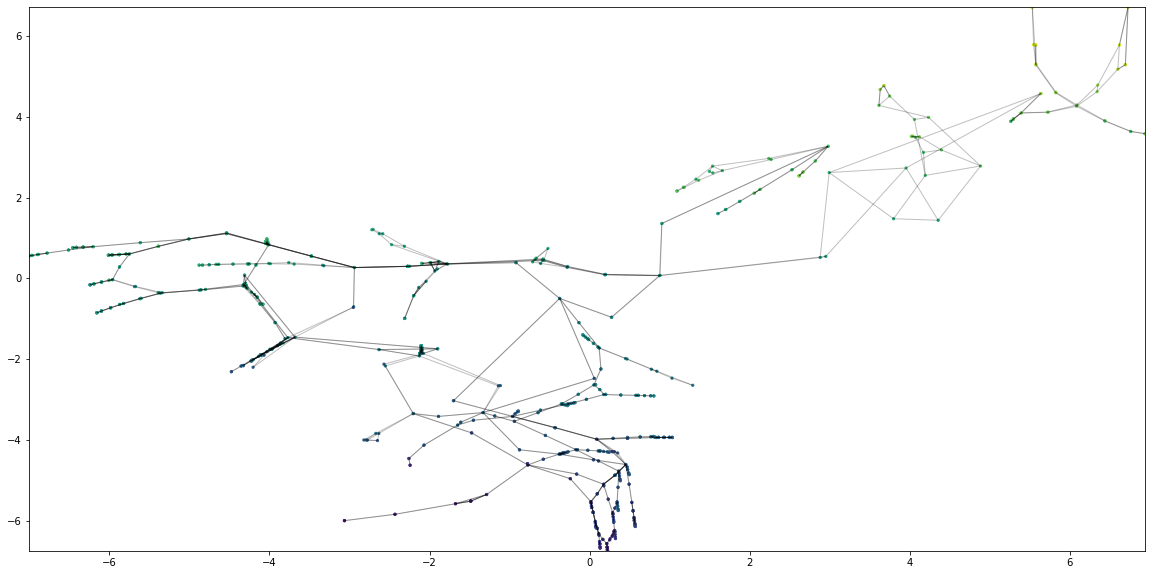

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt

The above exception was the direct cause of the following exception:

SystemError: <built-in method write of _io.BufferedWriter object at 0x7fdd7b460678> returned a result with an error set

The above exception was the direct cause of the following exception:

SystemError: <built-in method write of _io.BufferedWriter object at 0x7fdd7b460678> returned a result with an error set

The above exception was the direct cause of the following exception:

SystemError: <built-in method write of _io.FileIO object at 0x7fdd223fcb40> returned a result with an error set

The above exception was the direct cause of the following exception:

SystemError: <built-in method write of _io.BufferedWriter object at 0x7fdd7b460678> returned a result with an error set

The above exception was the direct cause of the following exception:

SystemError: <built-in method write of _io.BufferedWriter object at 0x7fdd7b460678> returned a result with an error set

The above exception was the direct

TypeError: object of type 'NoneType' has no len()

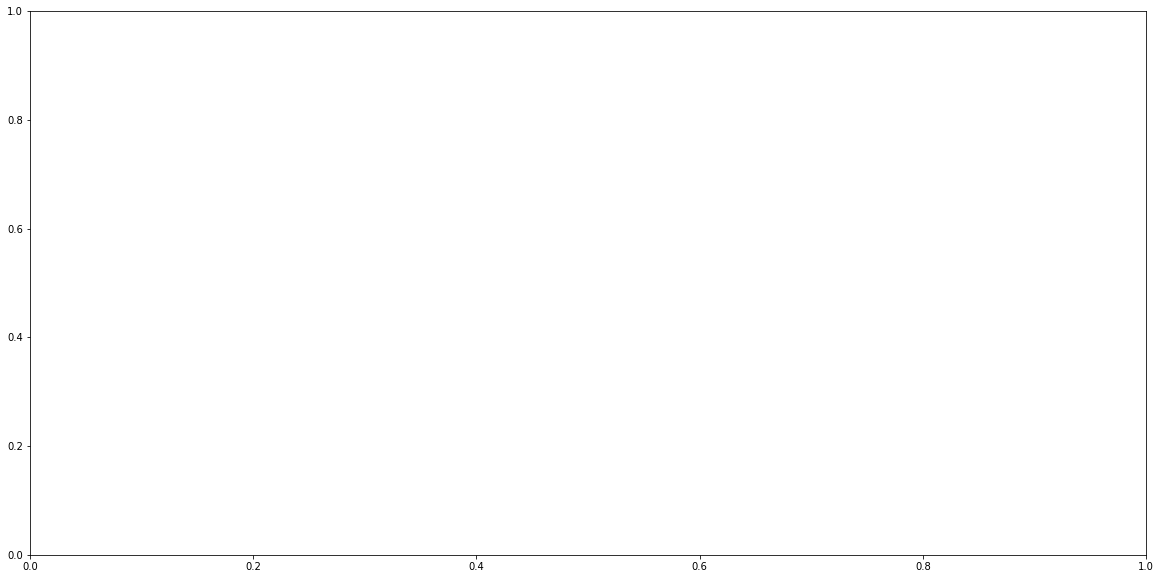

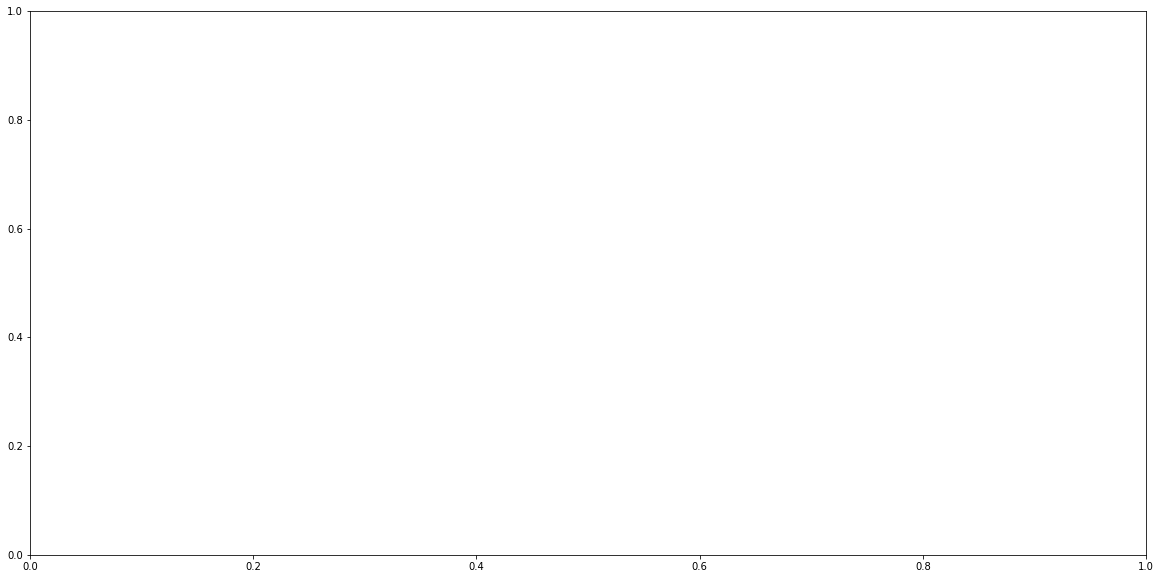

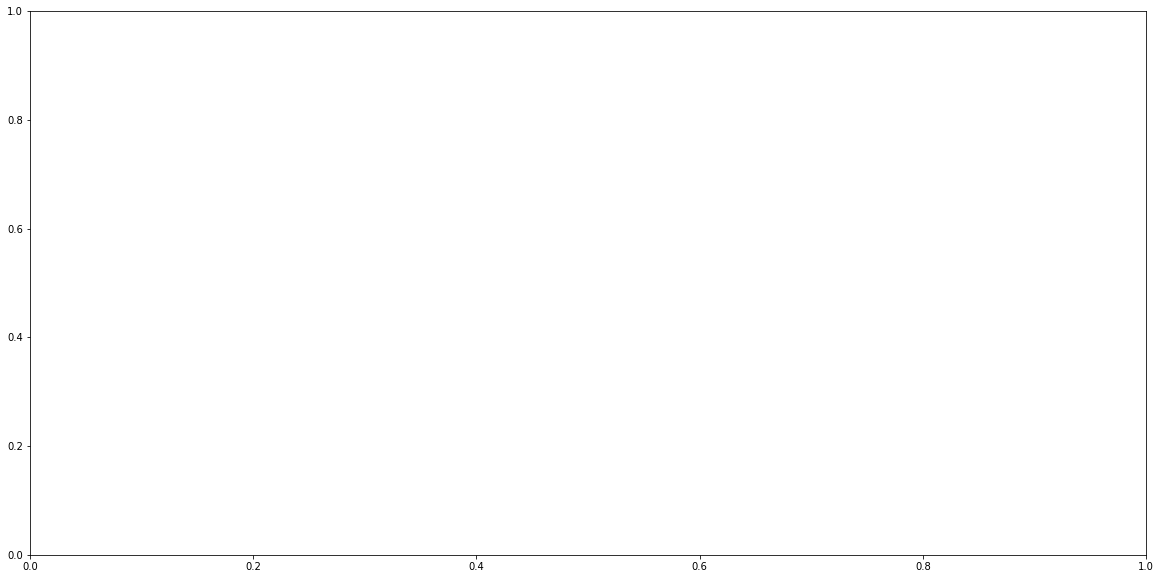

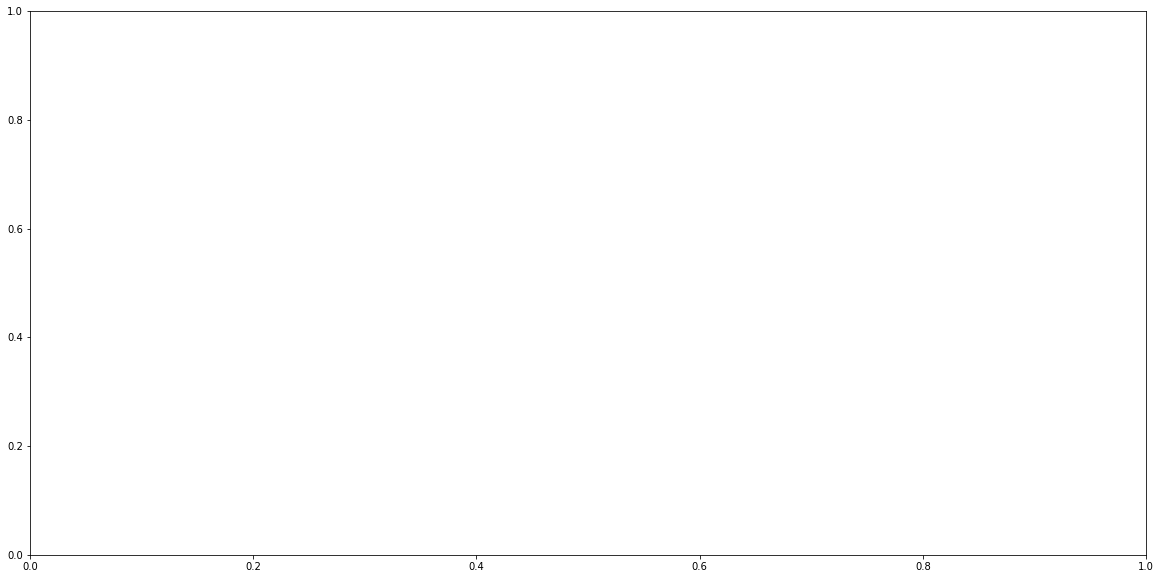

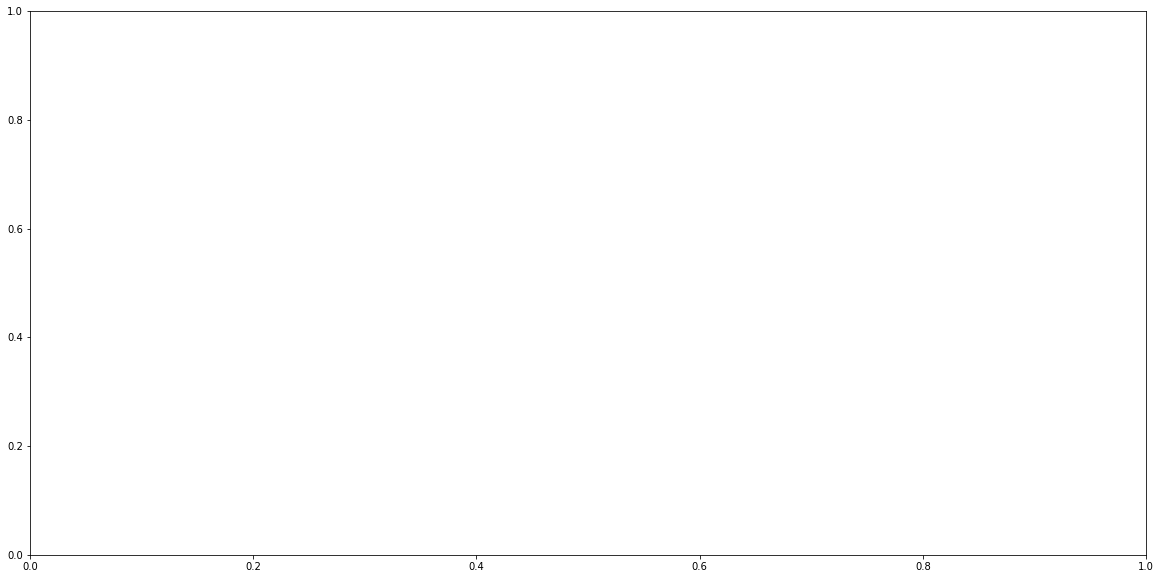

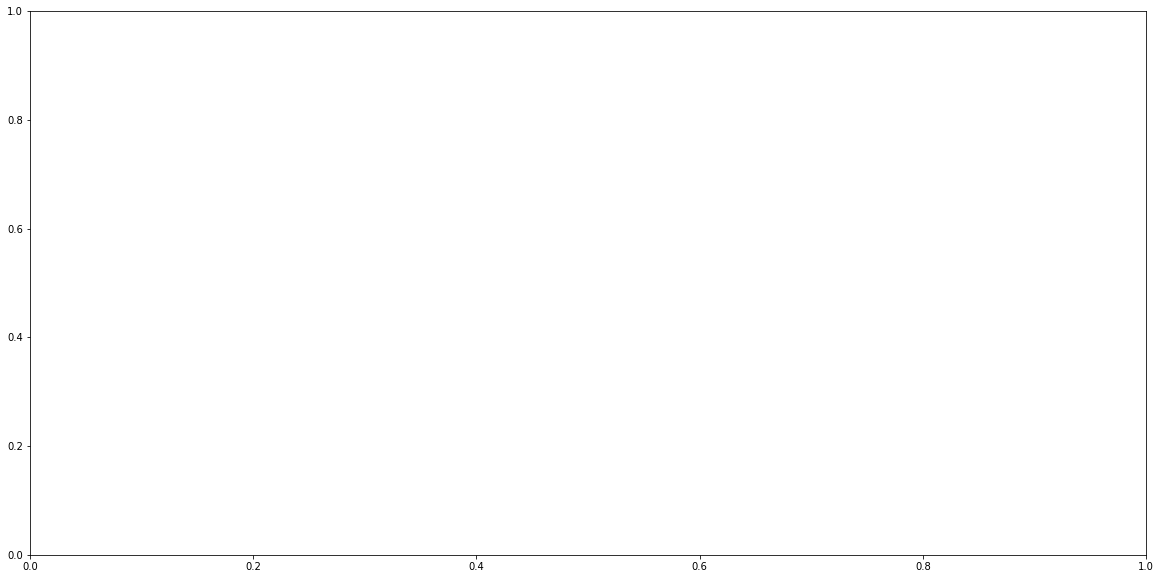

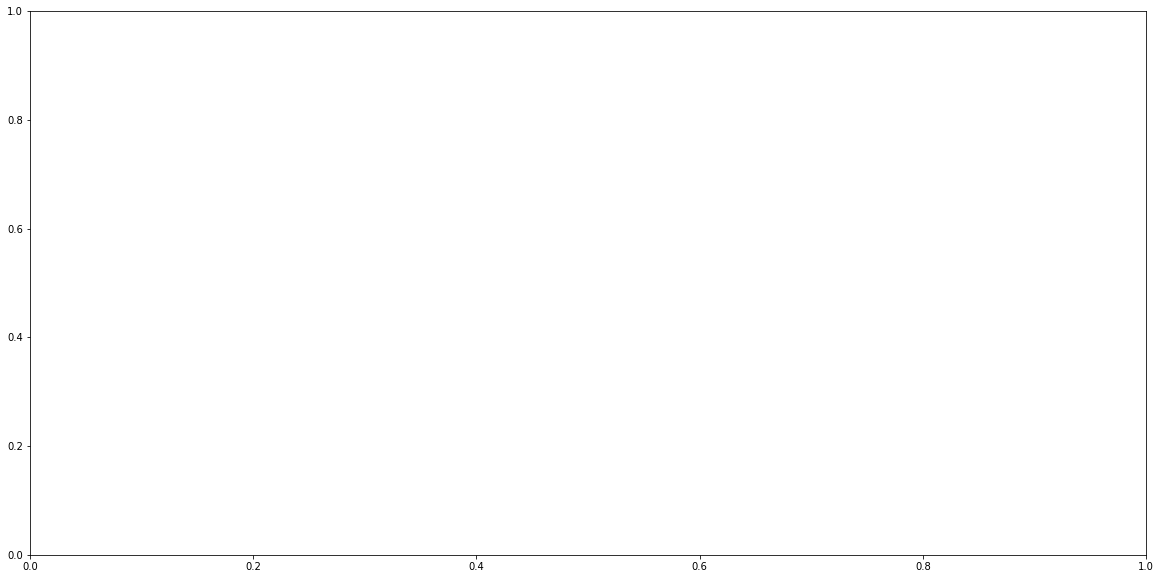

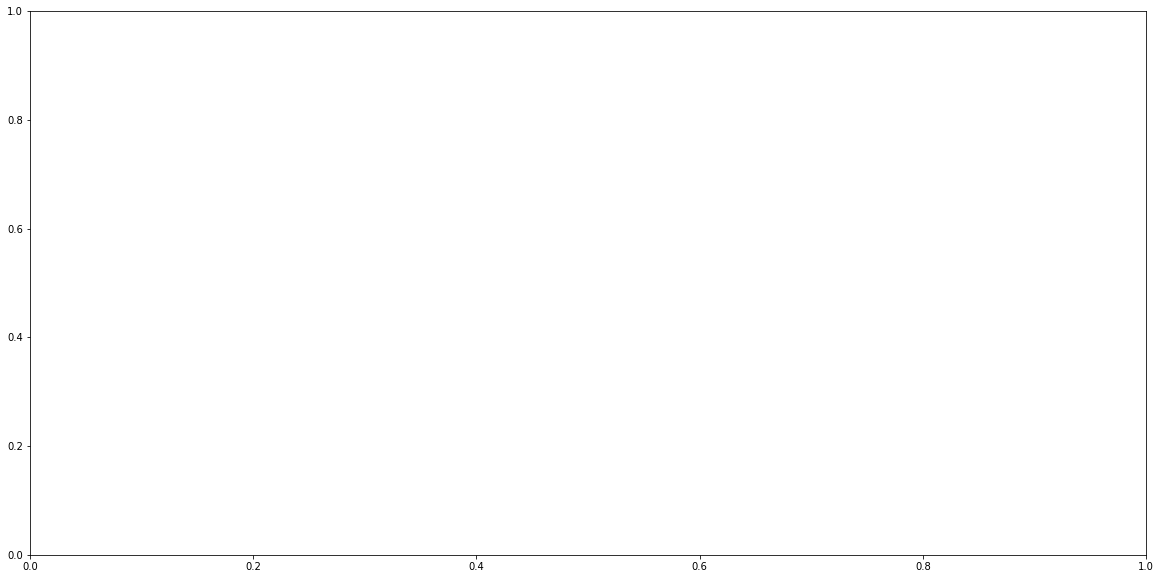

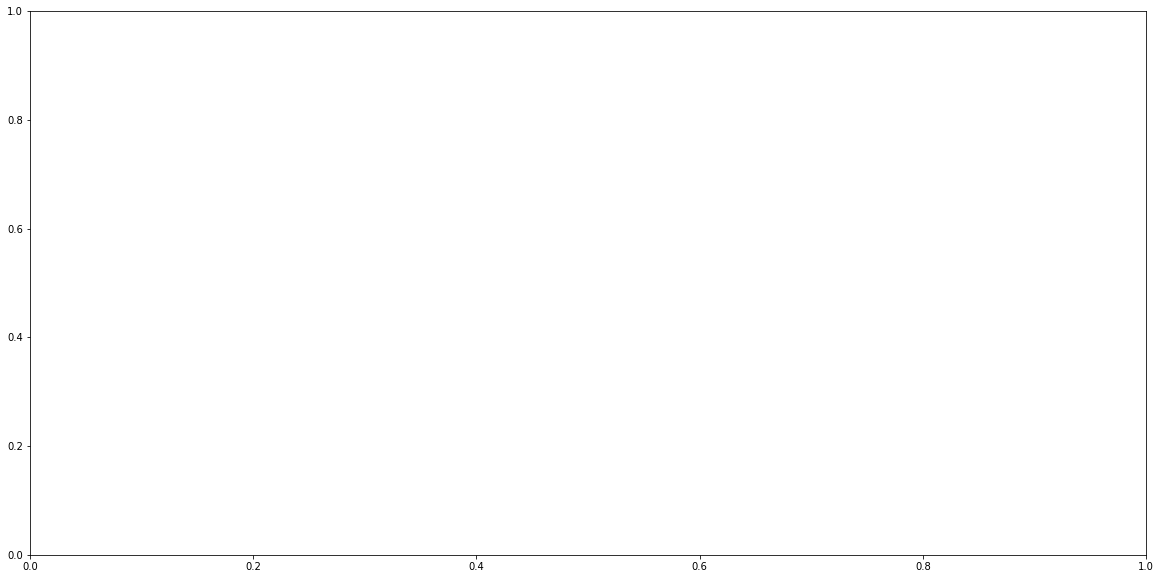

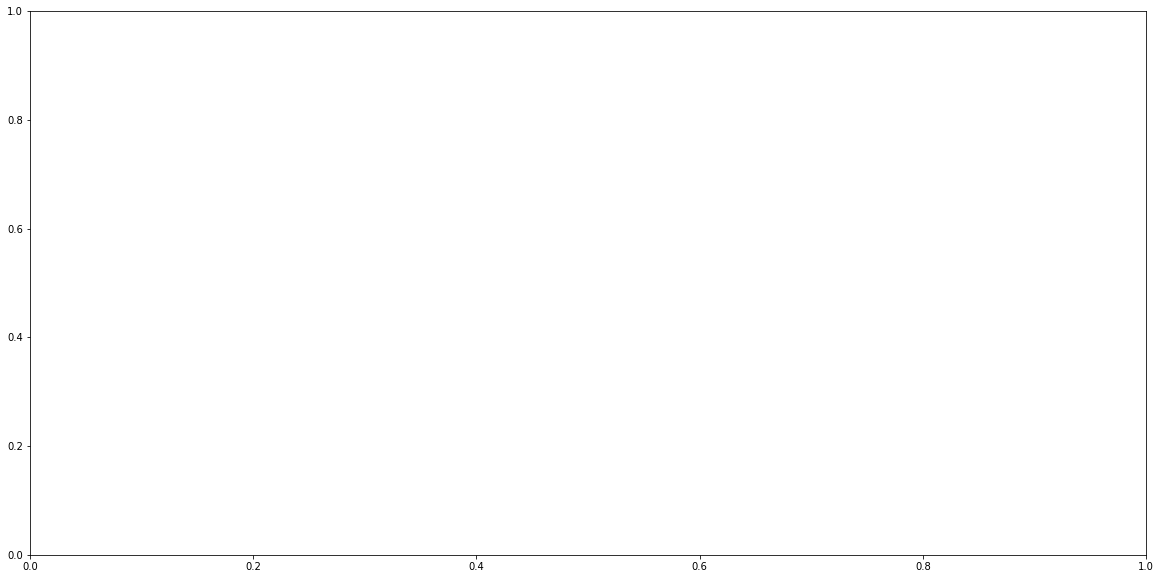

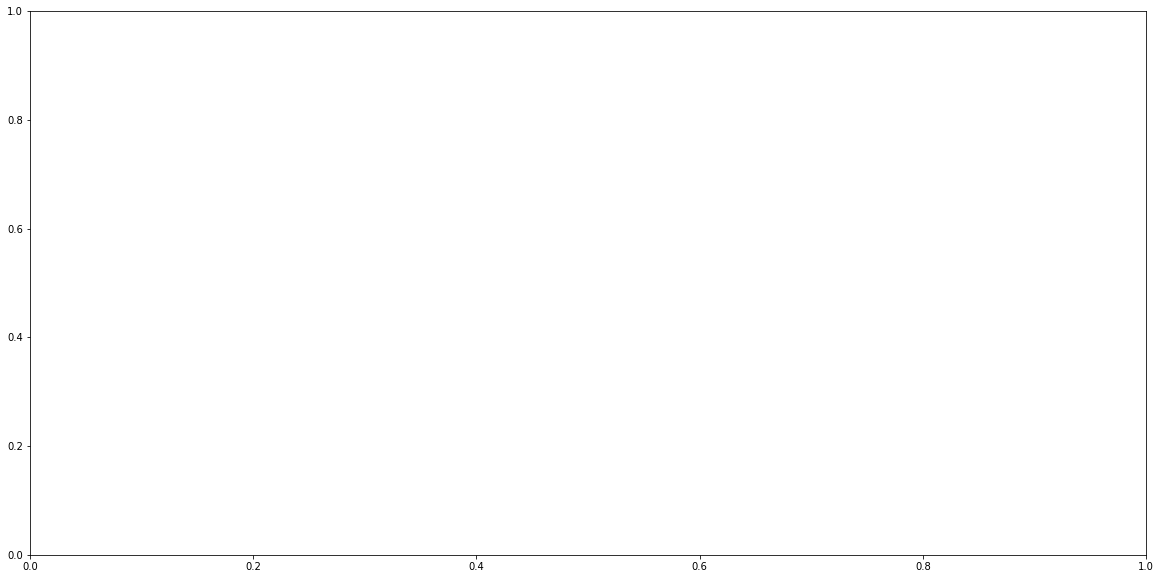

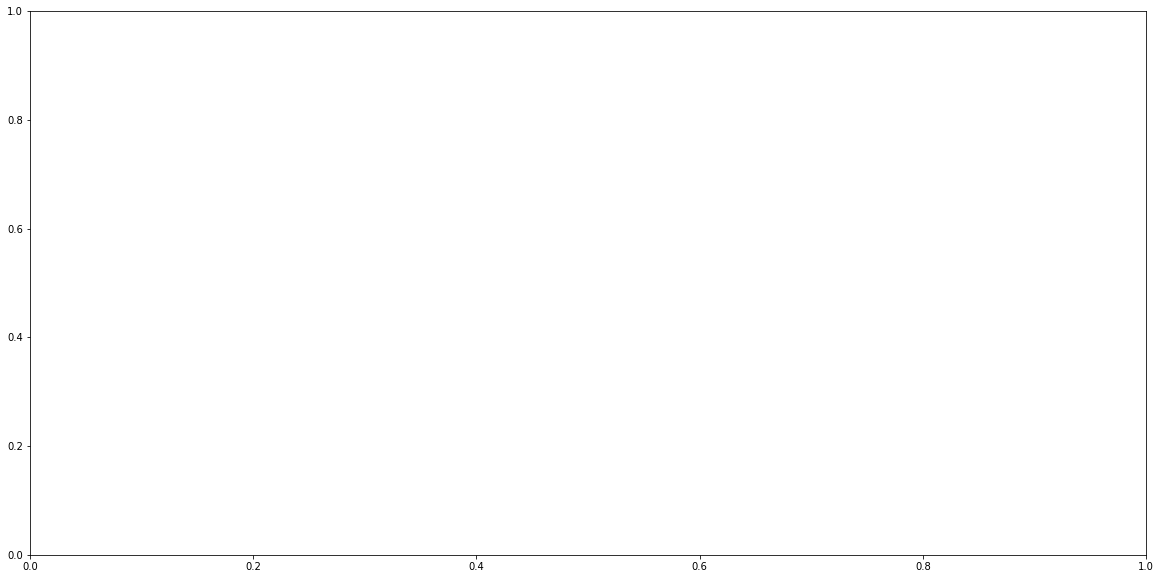

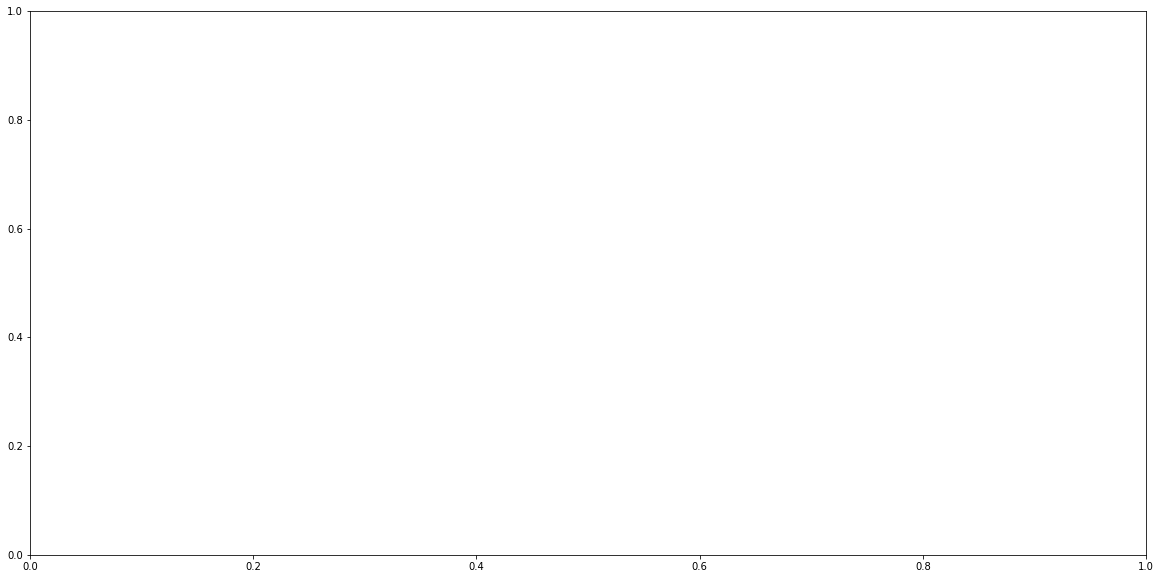

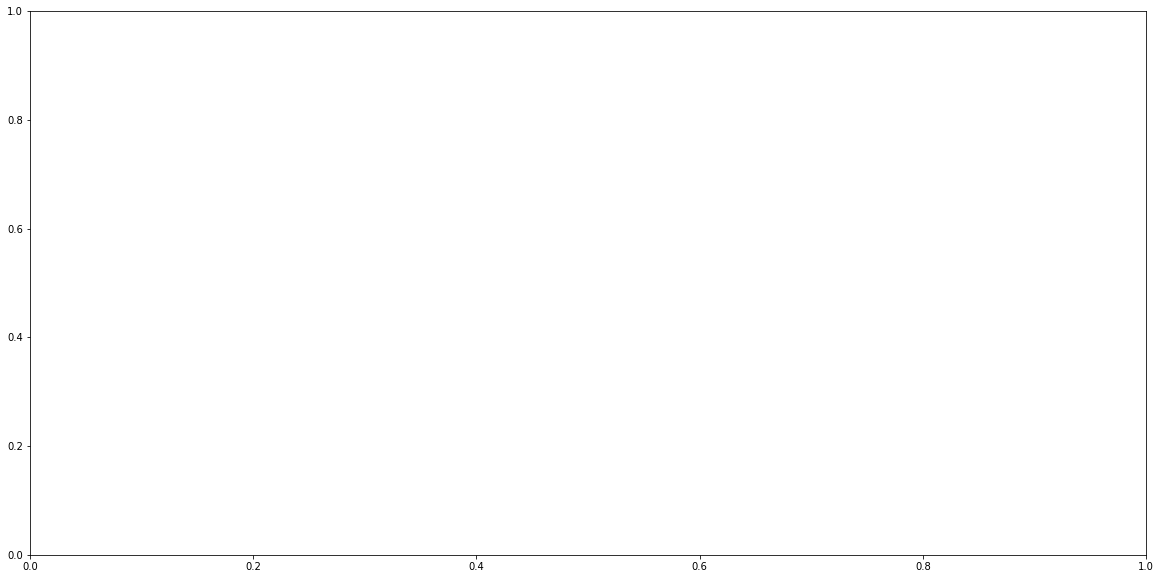

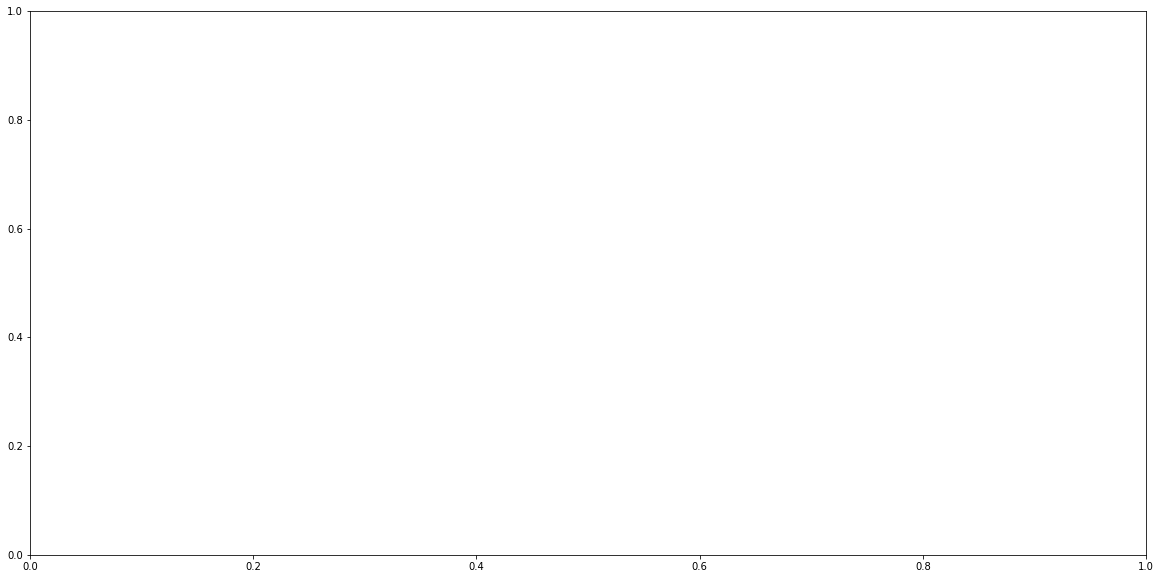

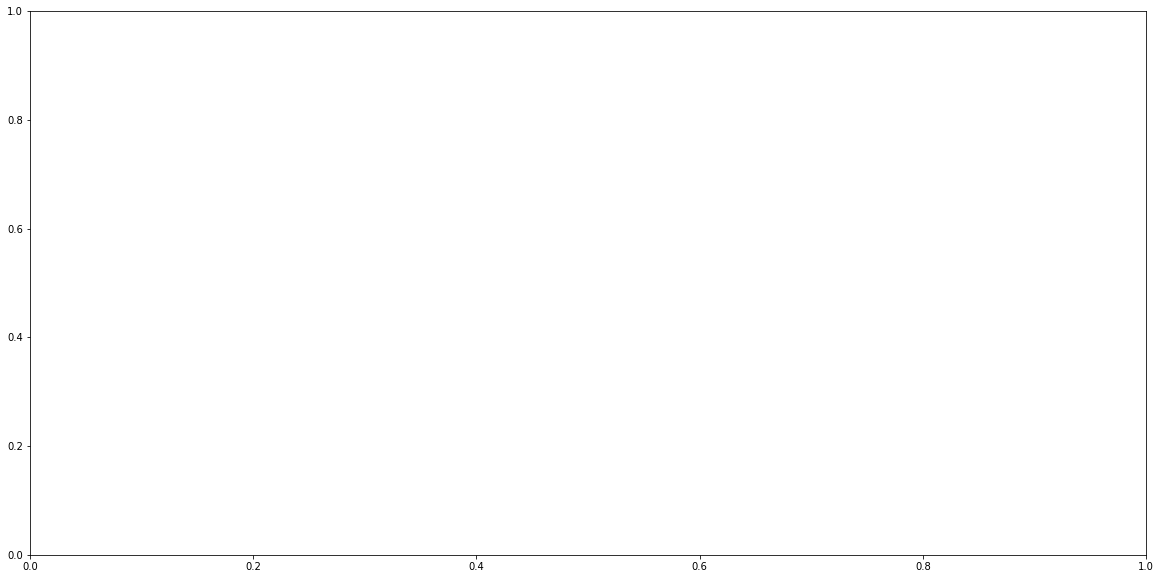

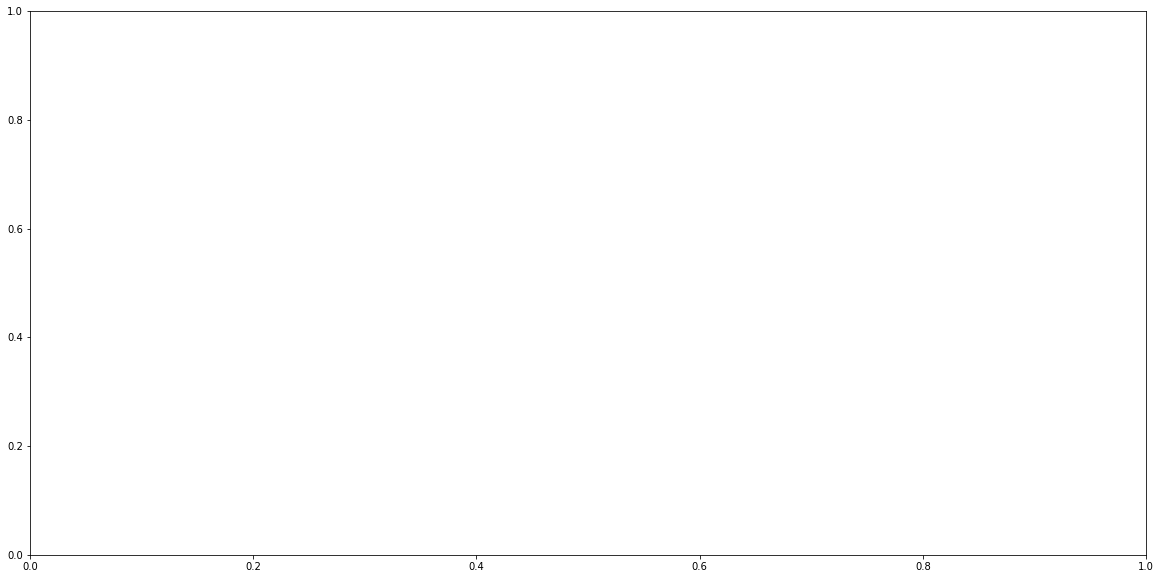

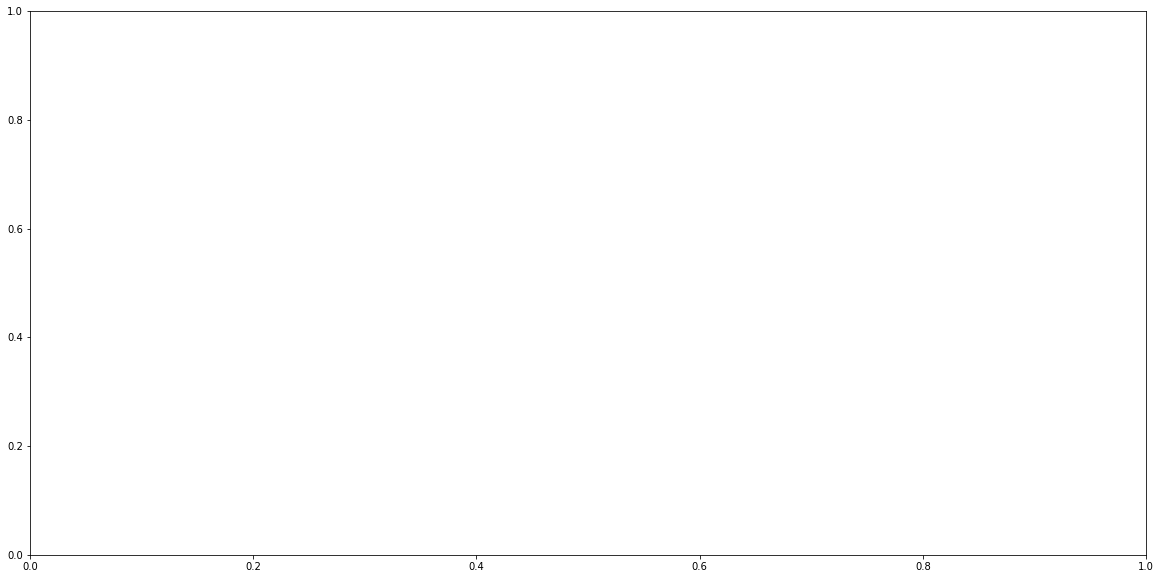

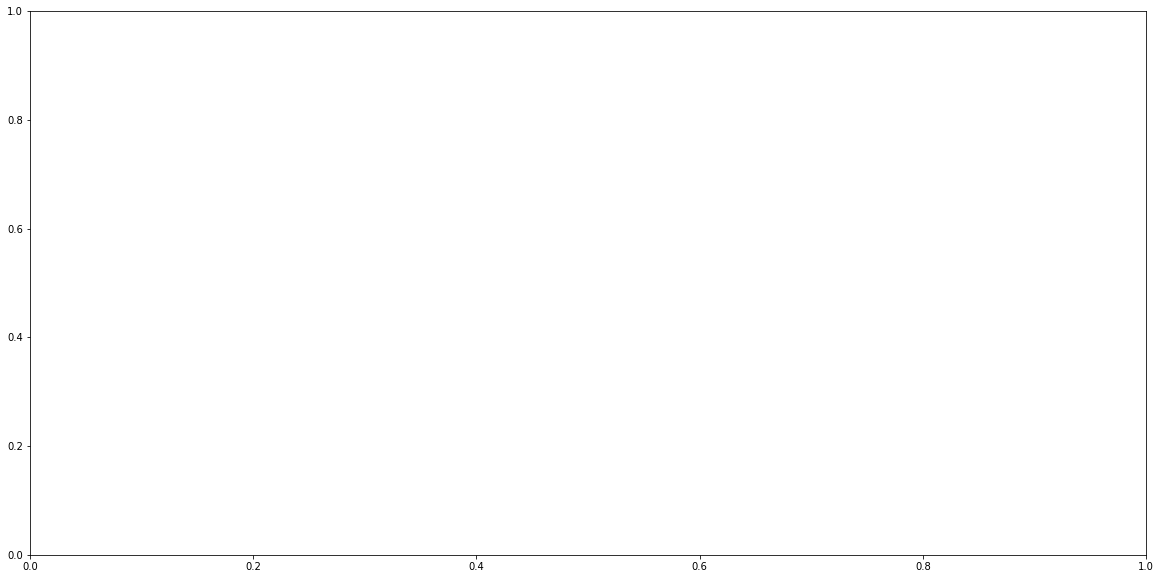

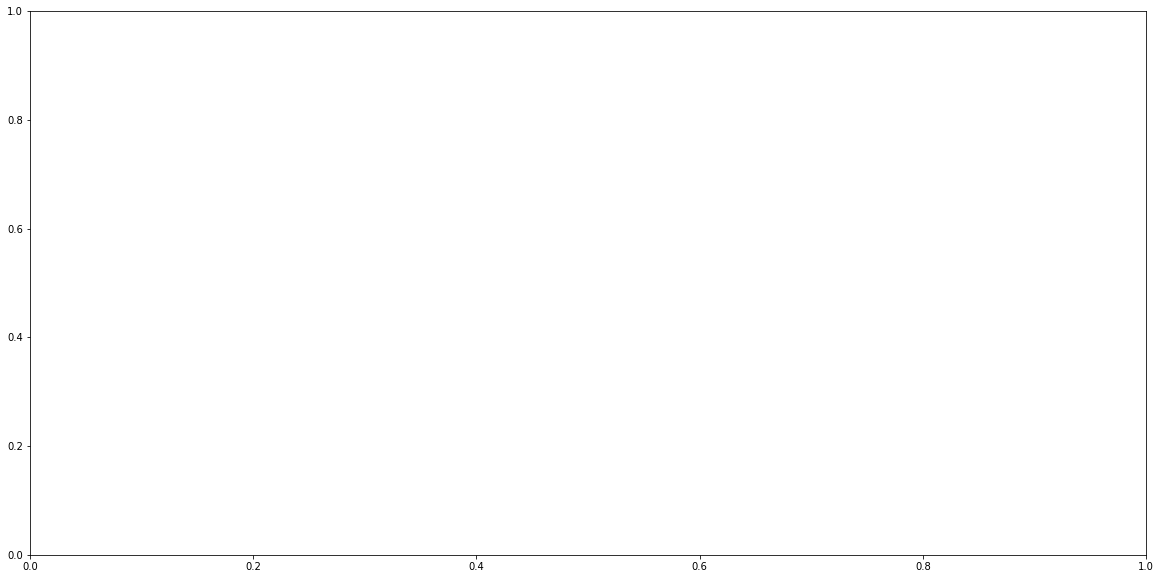

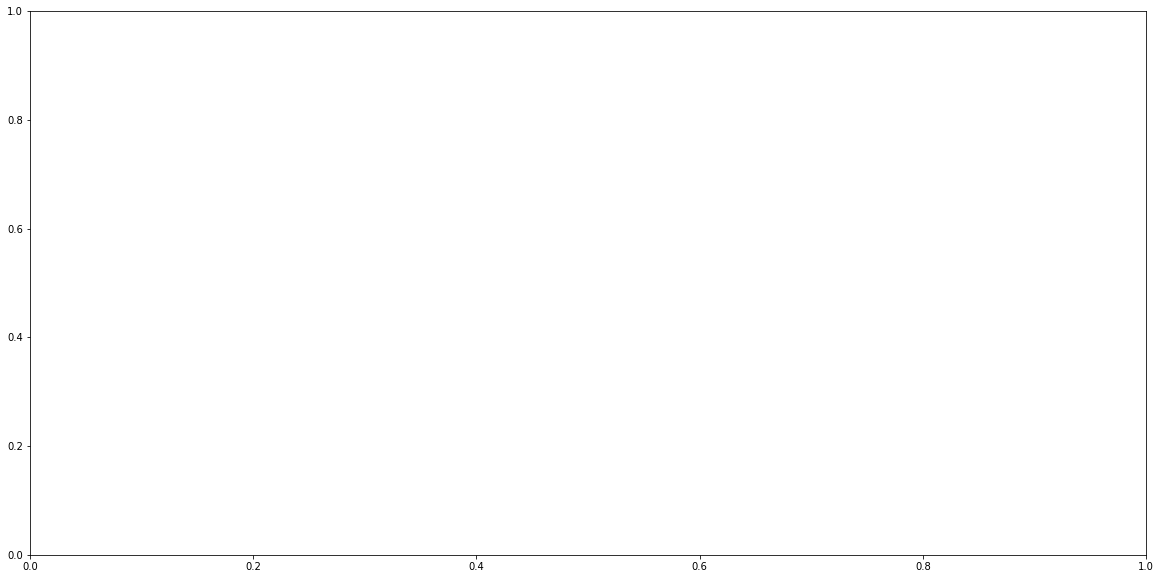

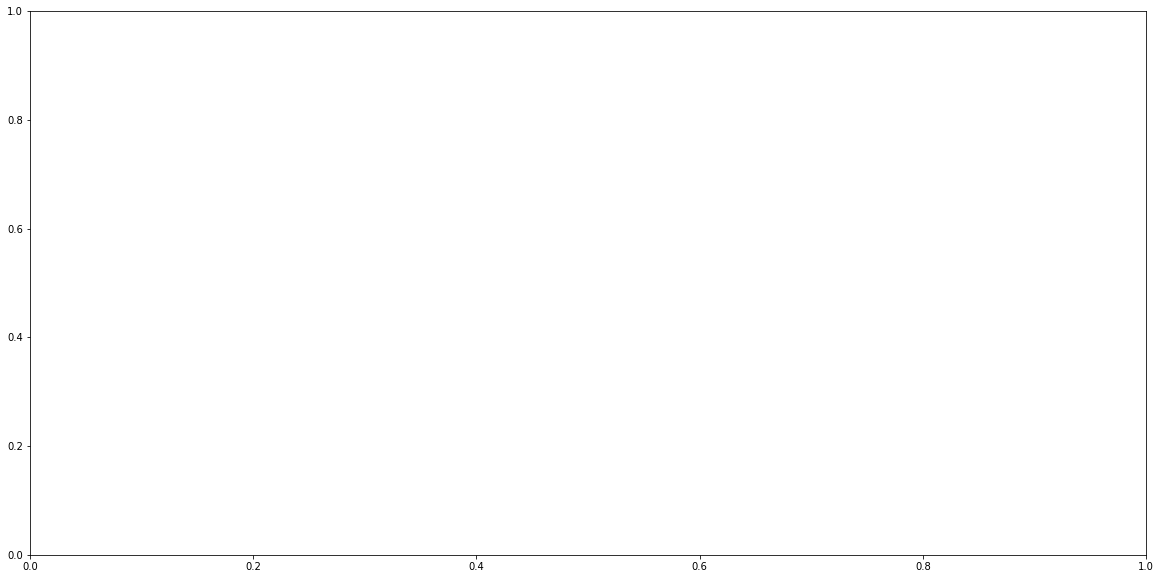

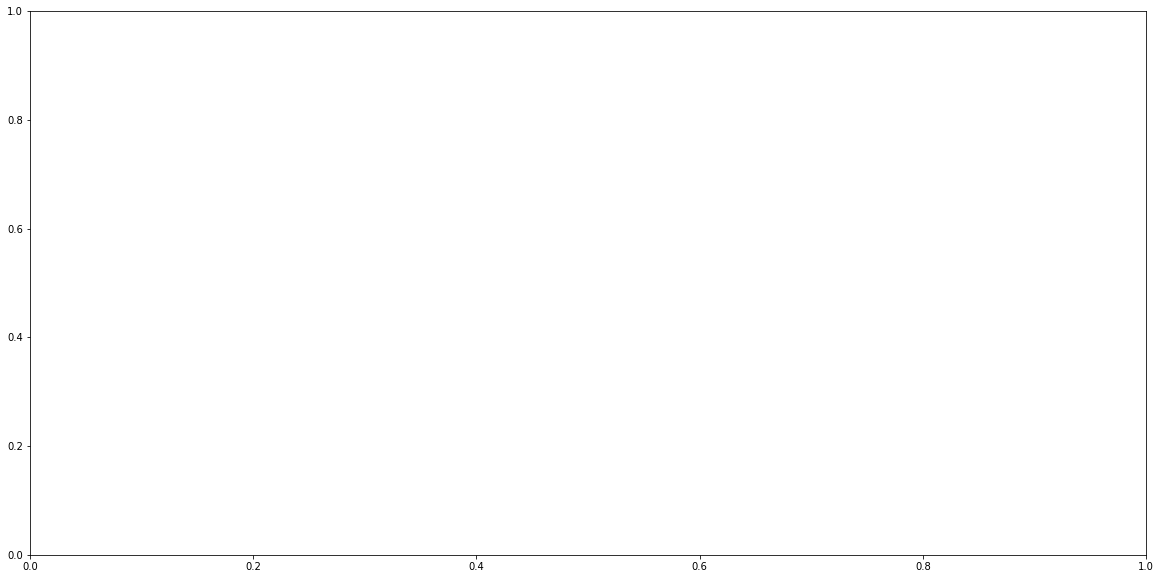

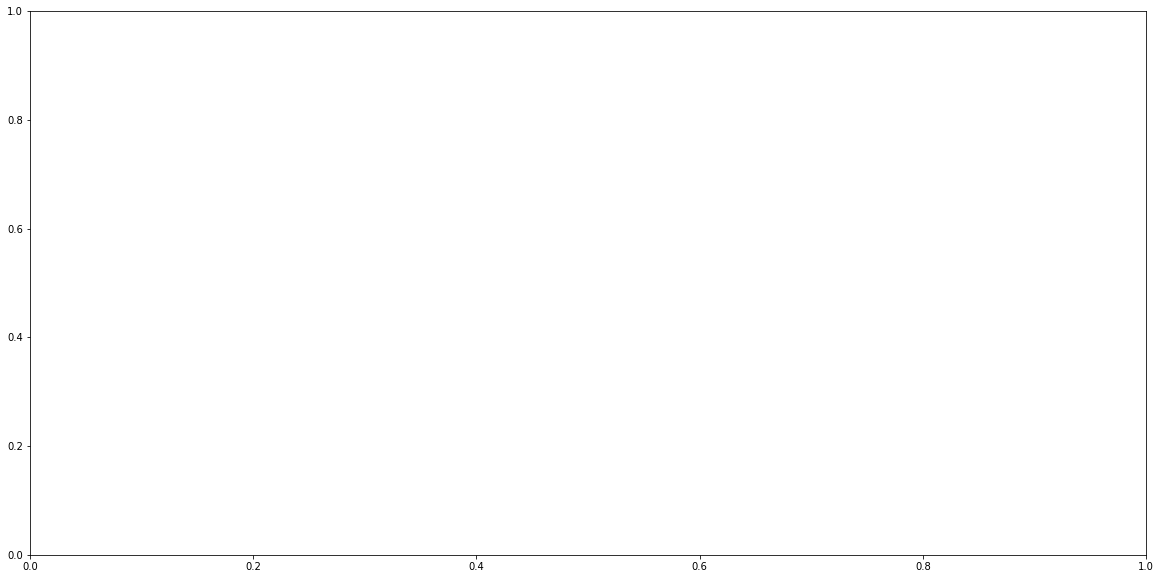

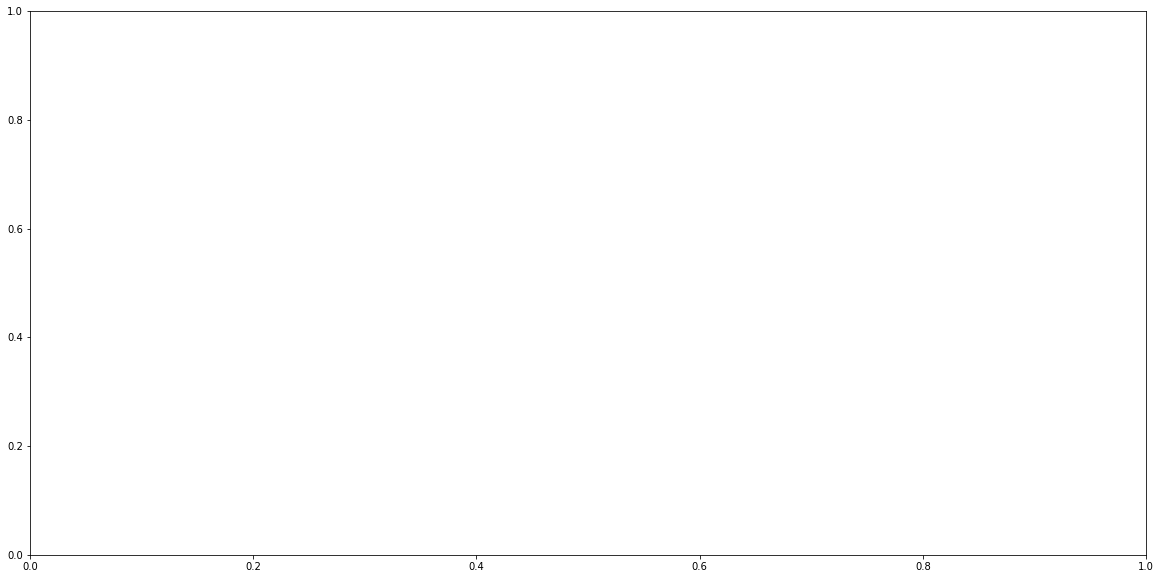

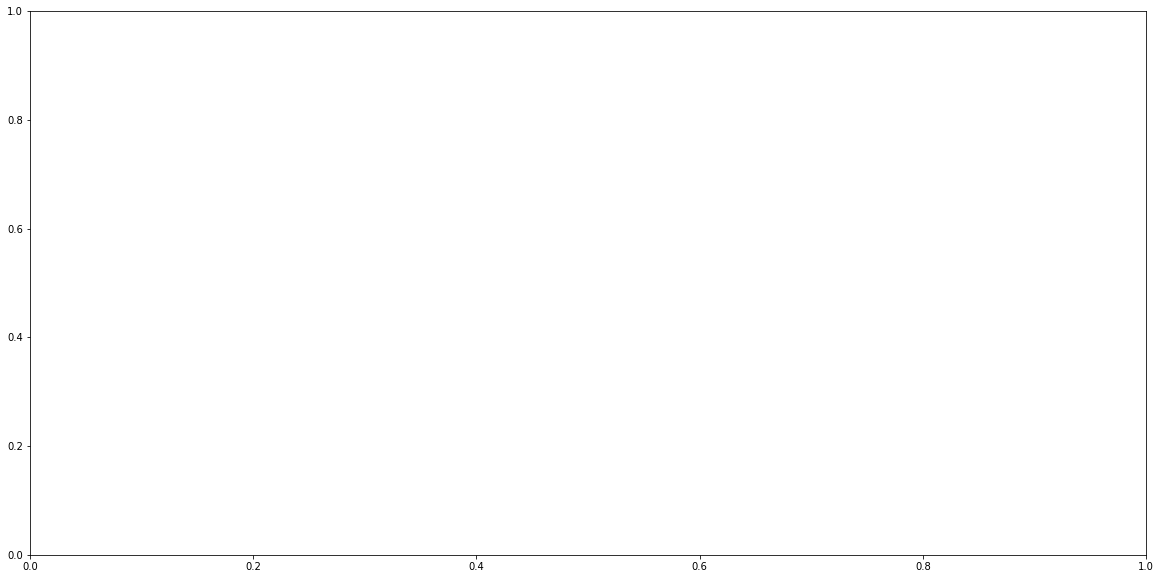

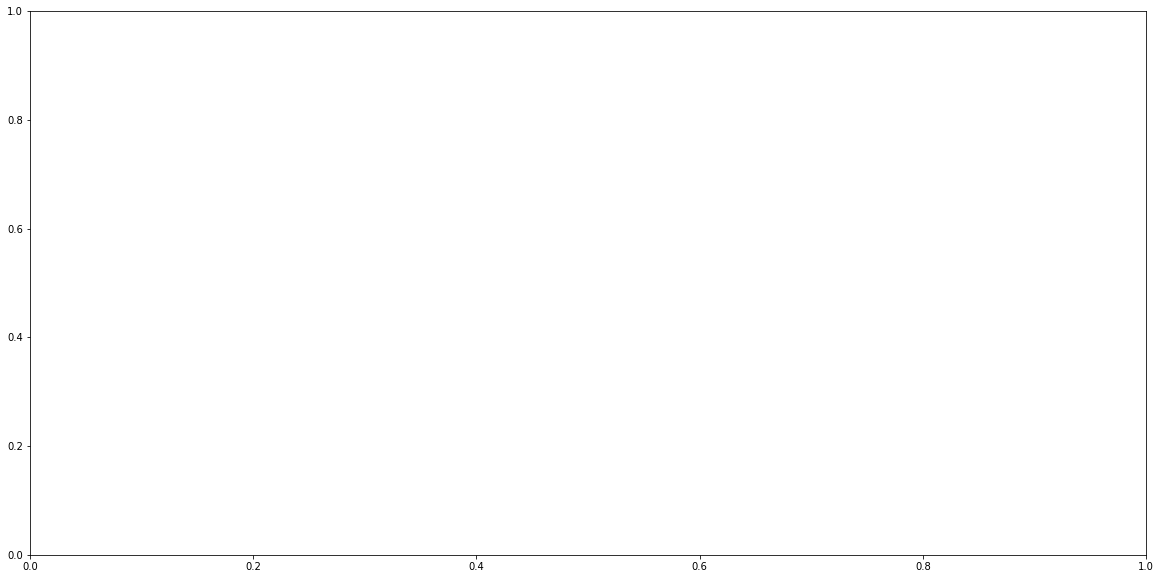

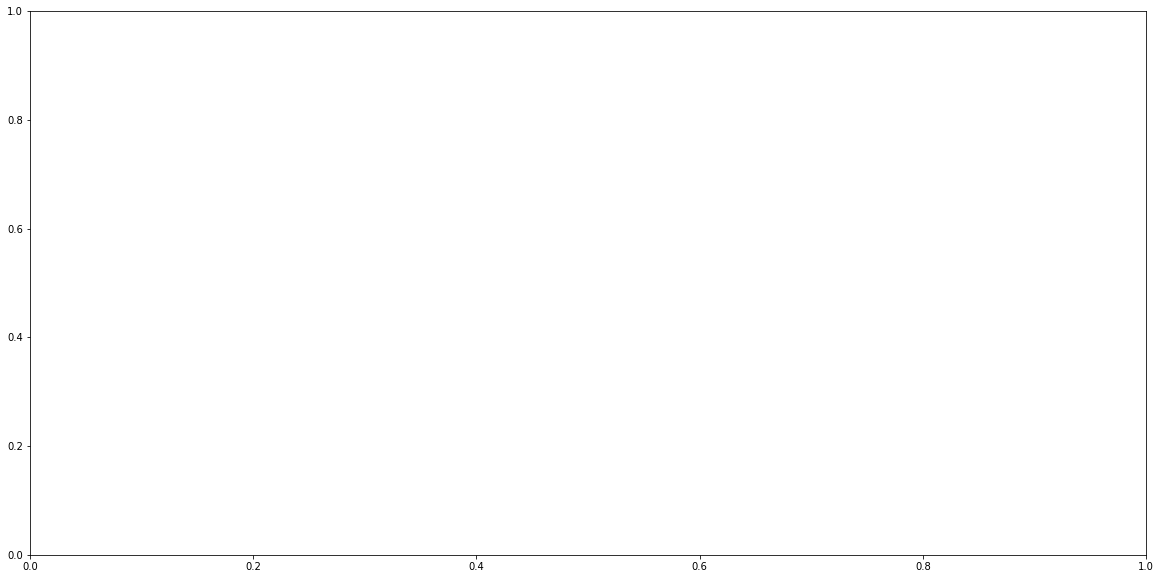

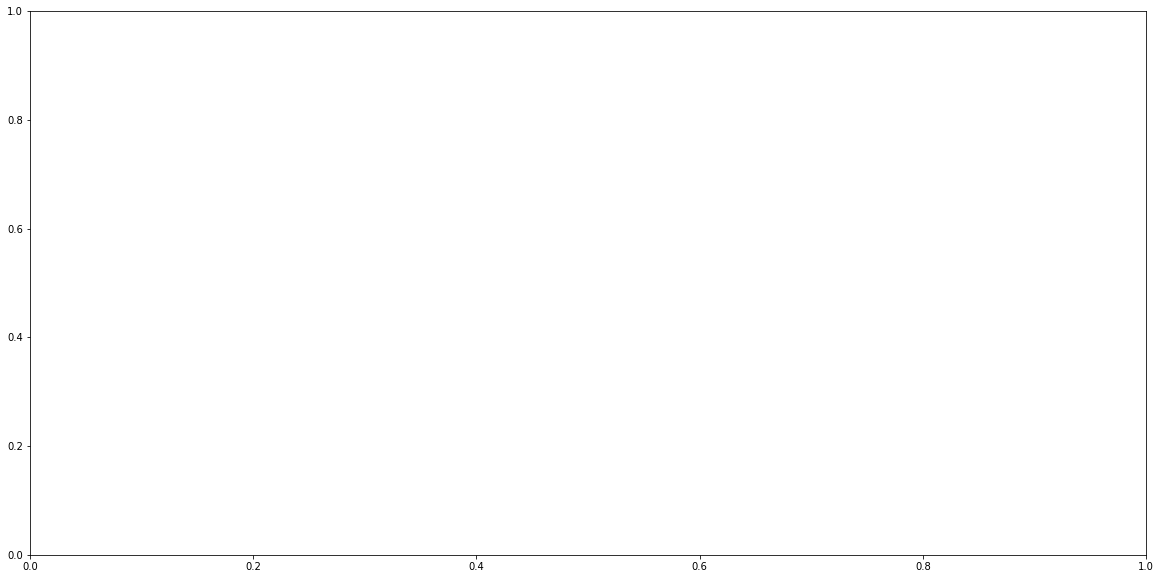

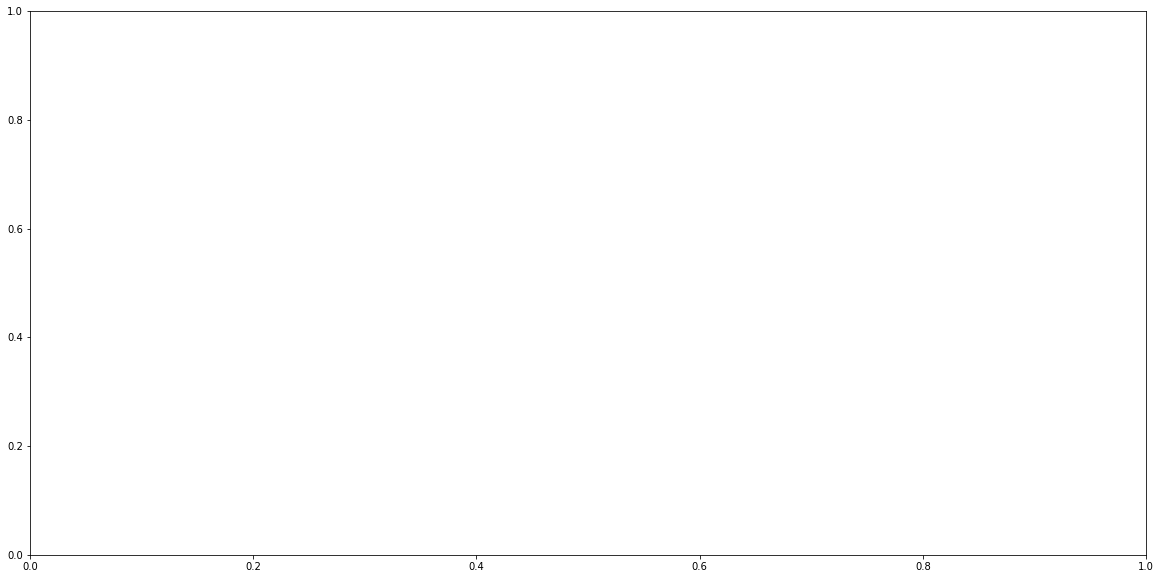

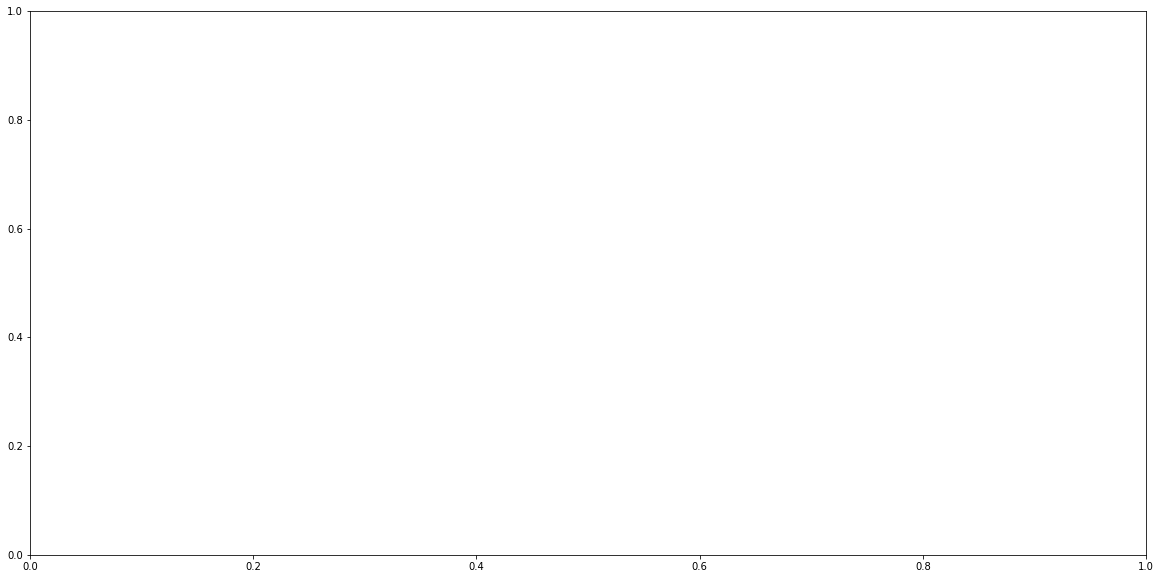

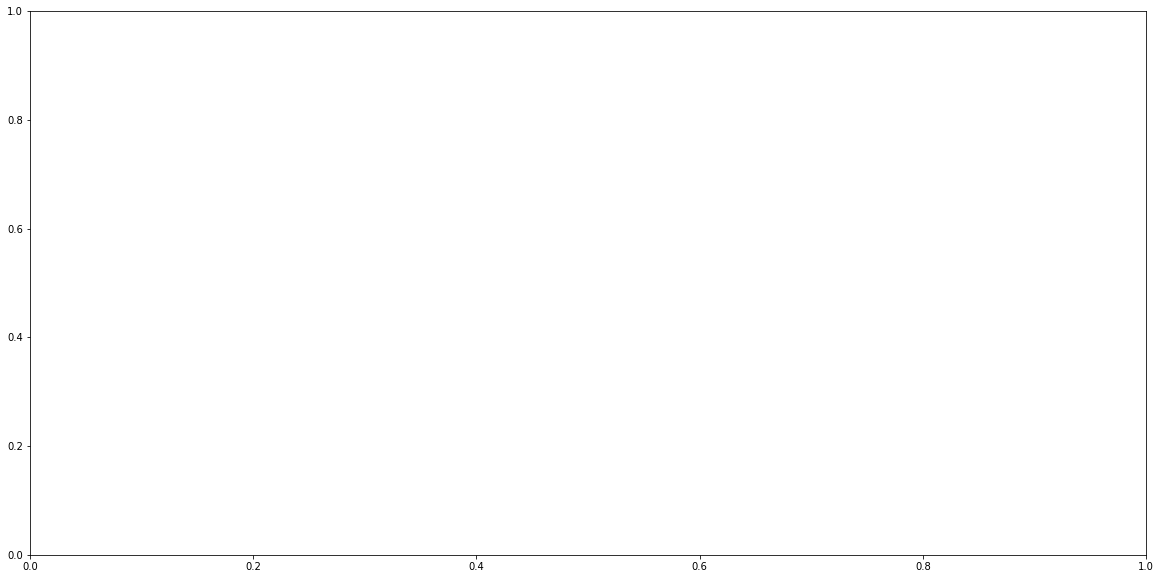

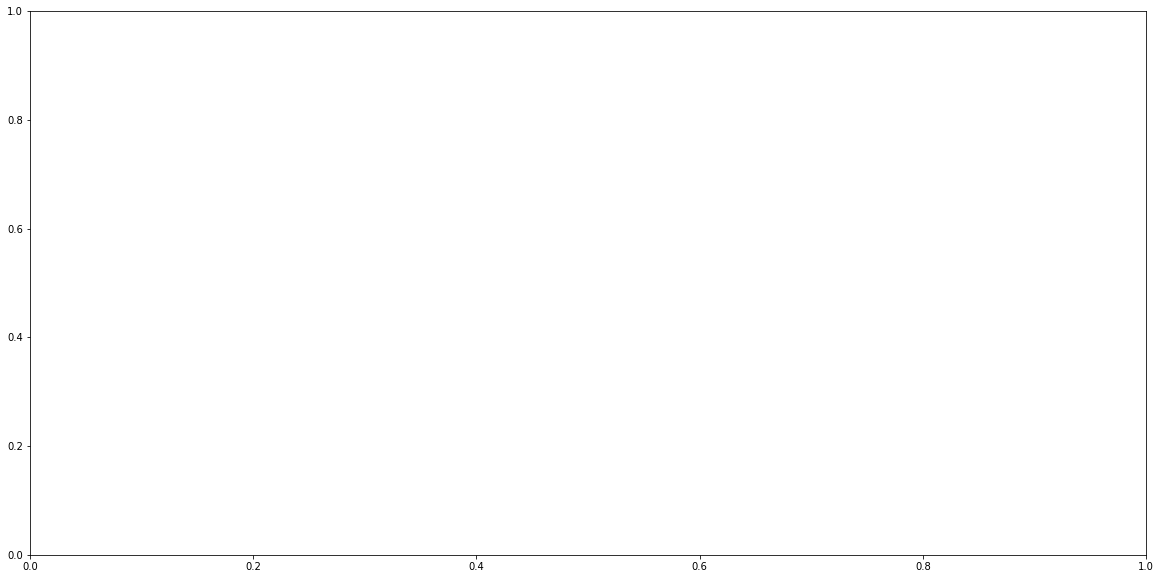

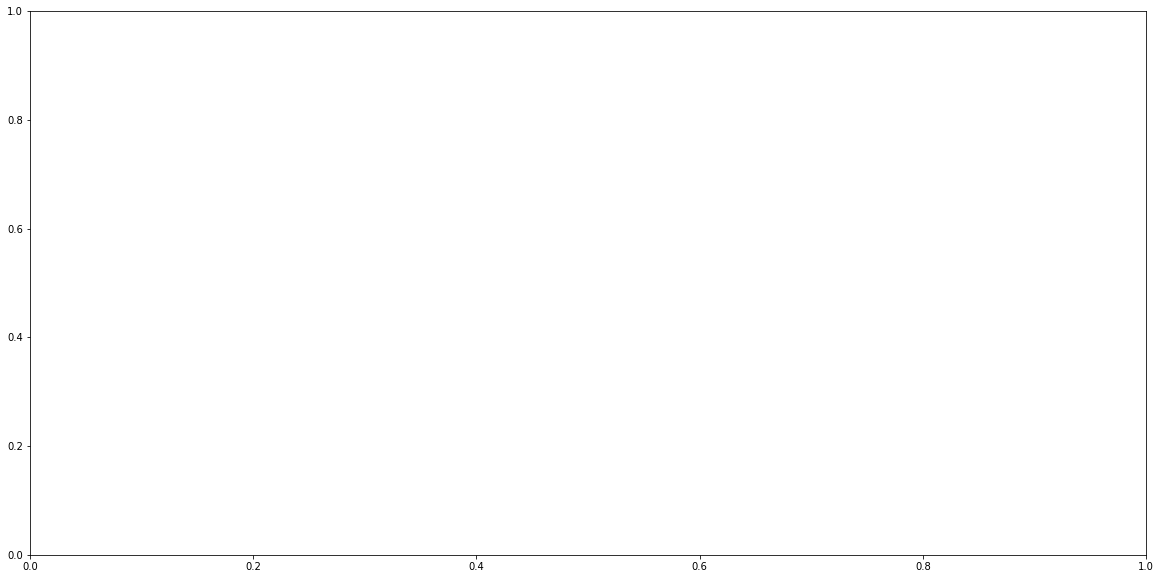

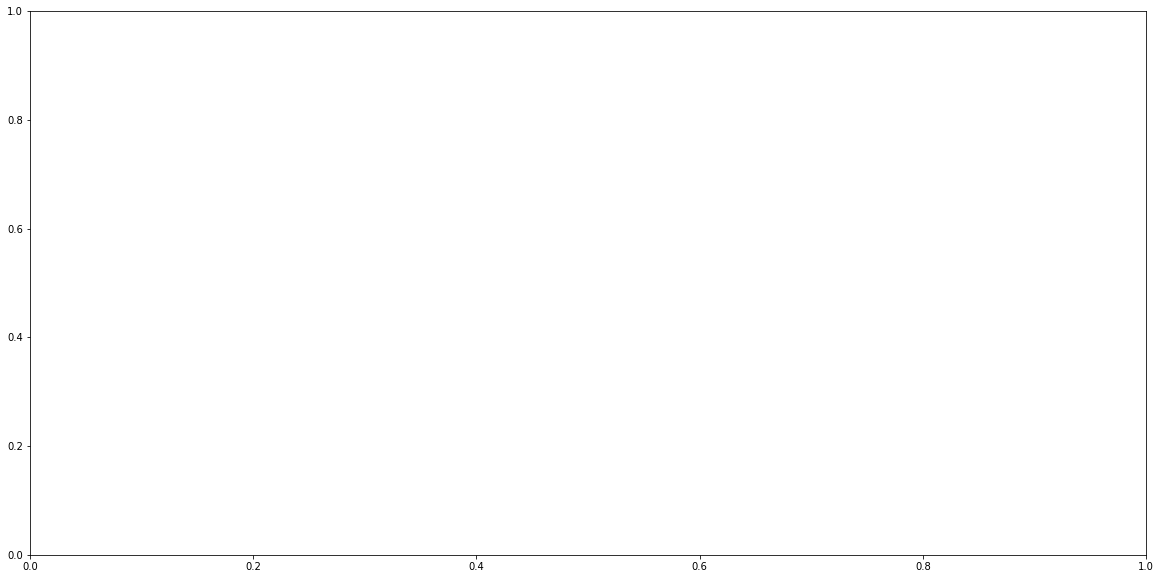

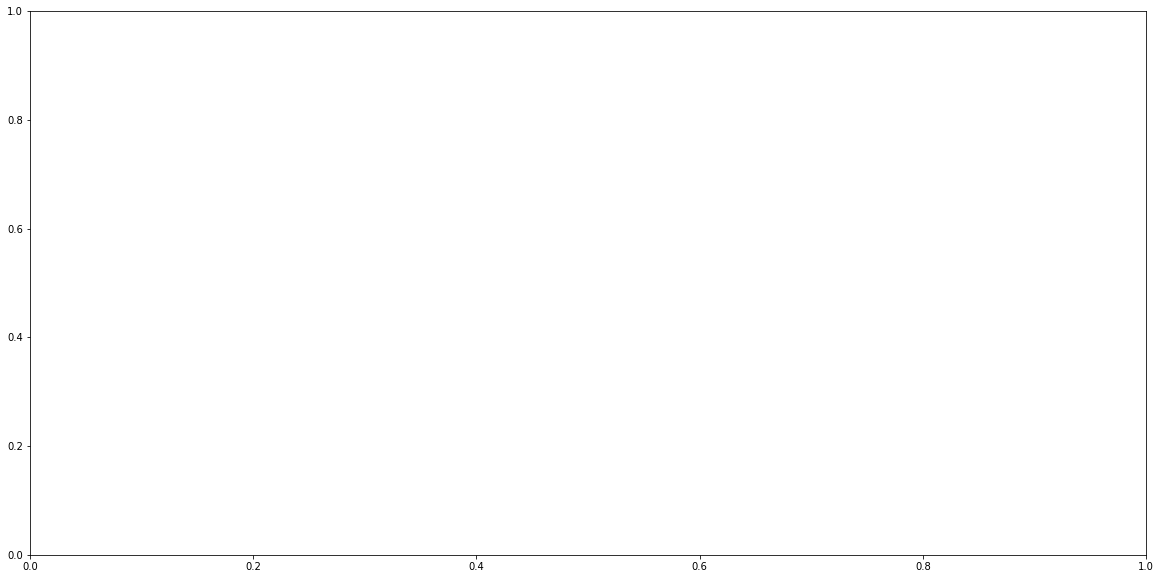

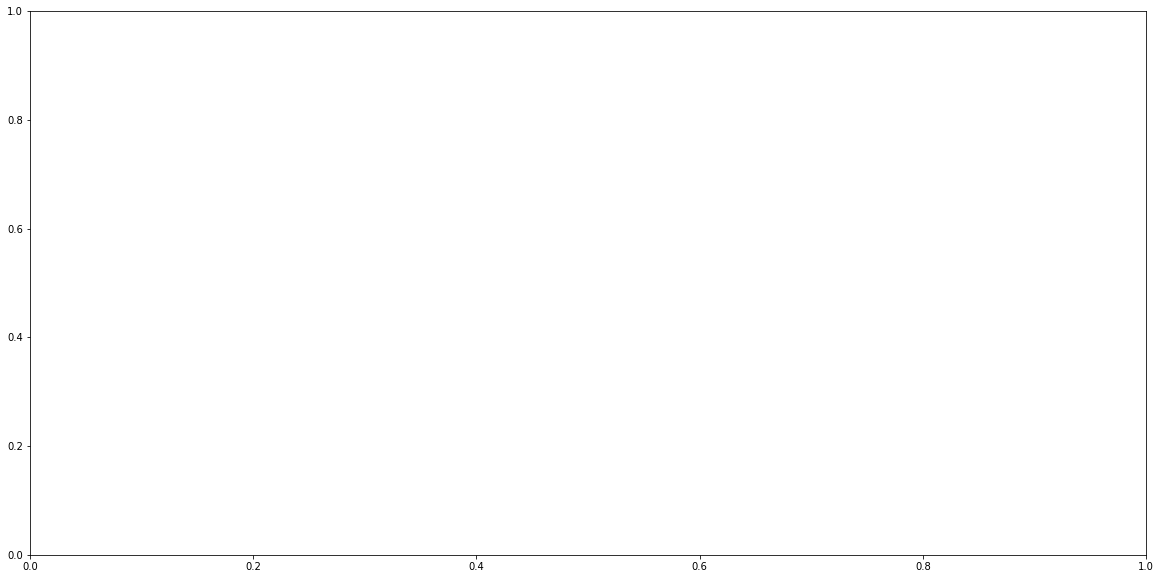

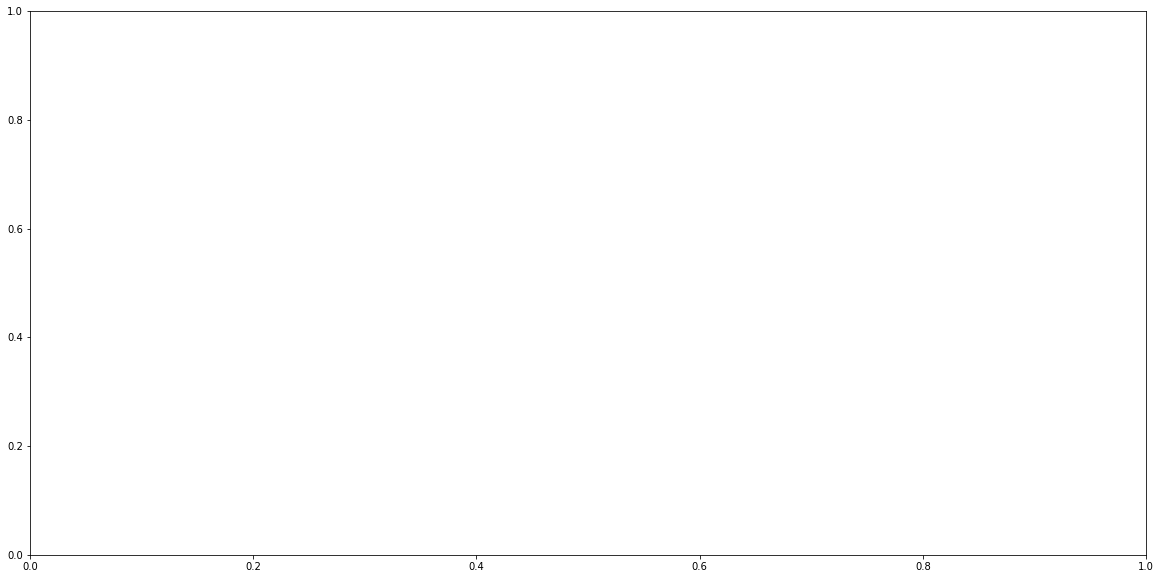

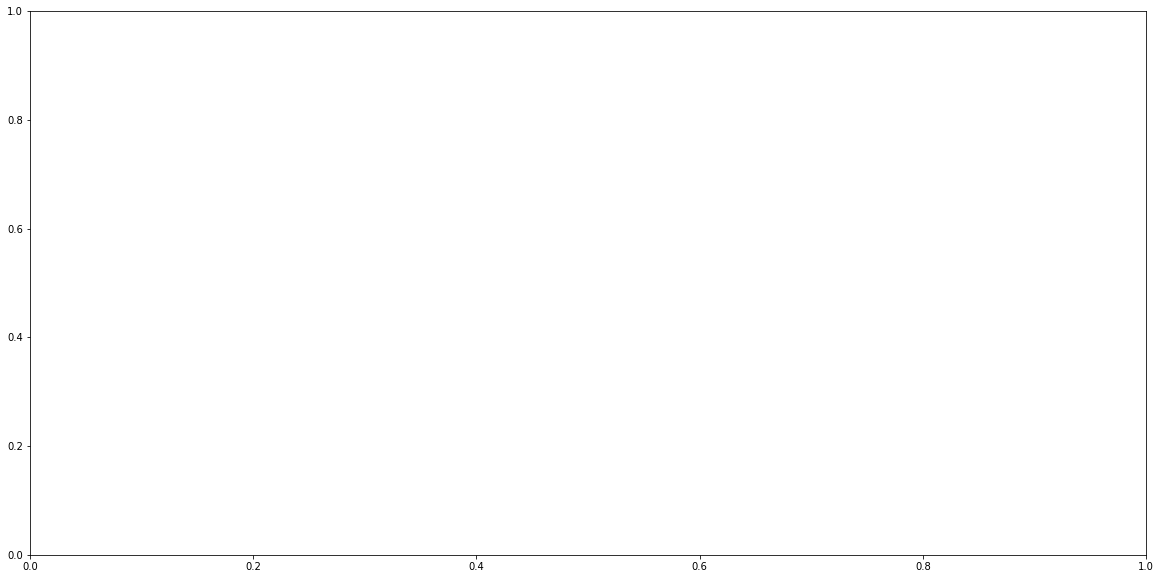

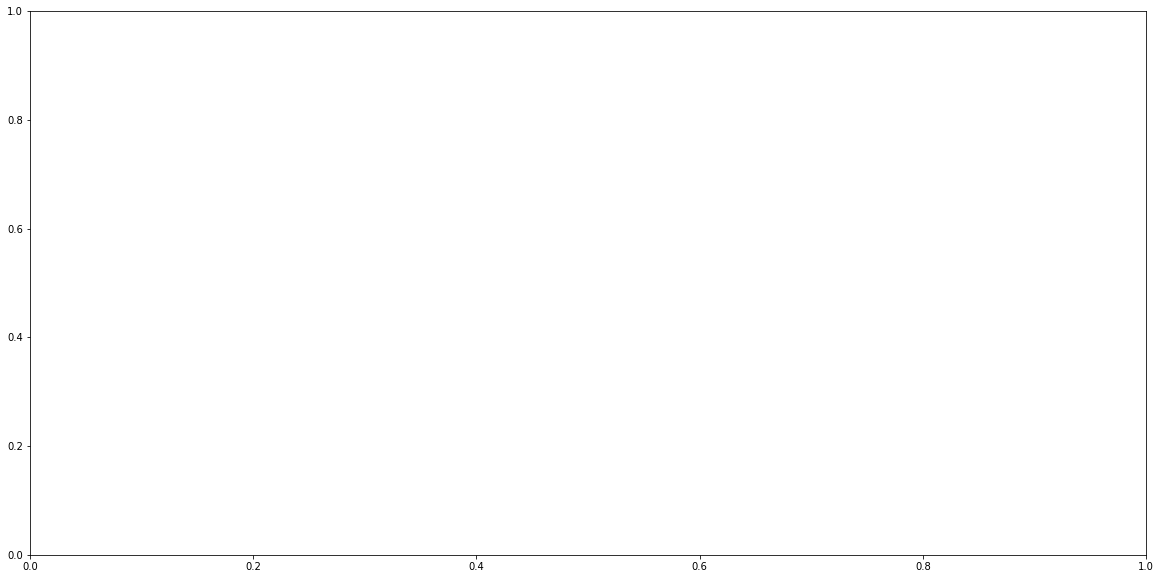

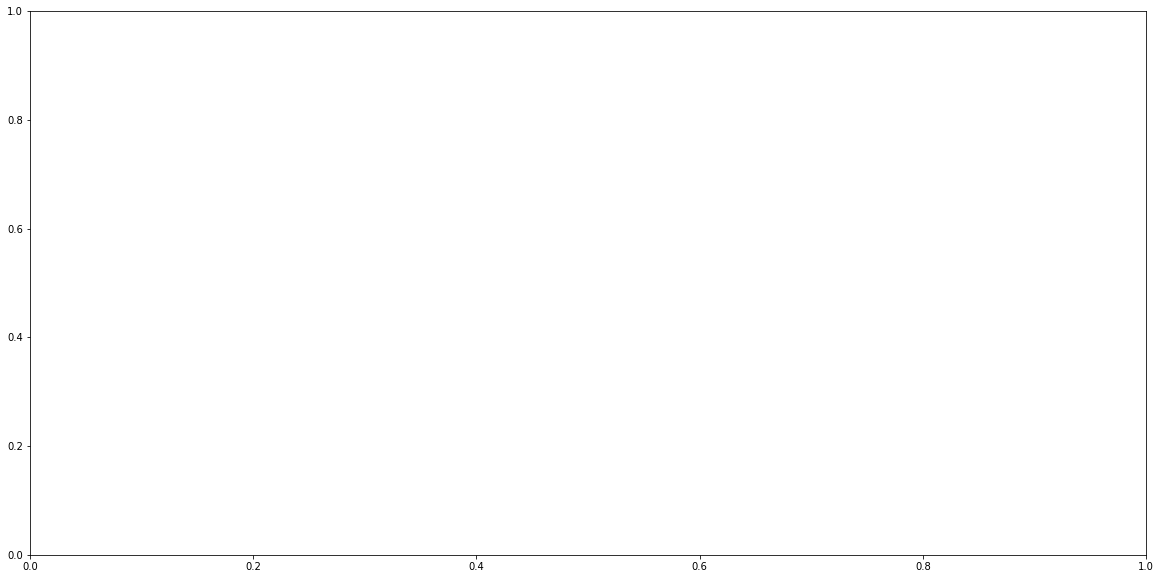

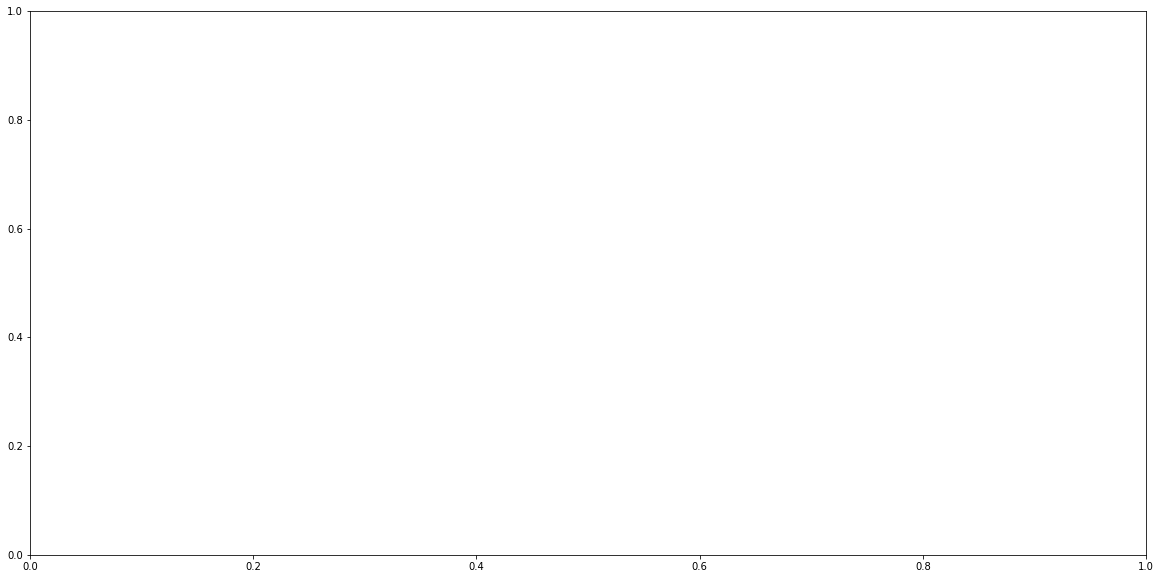

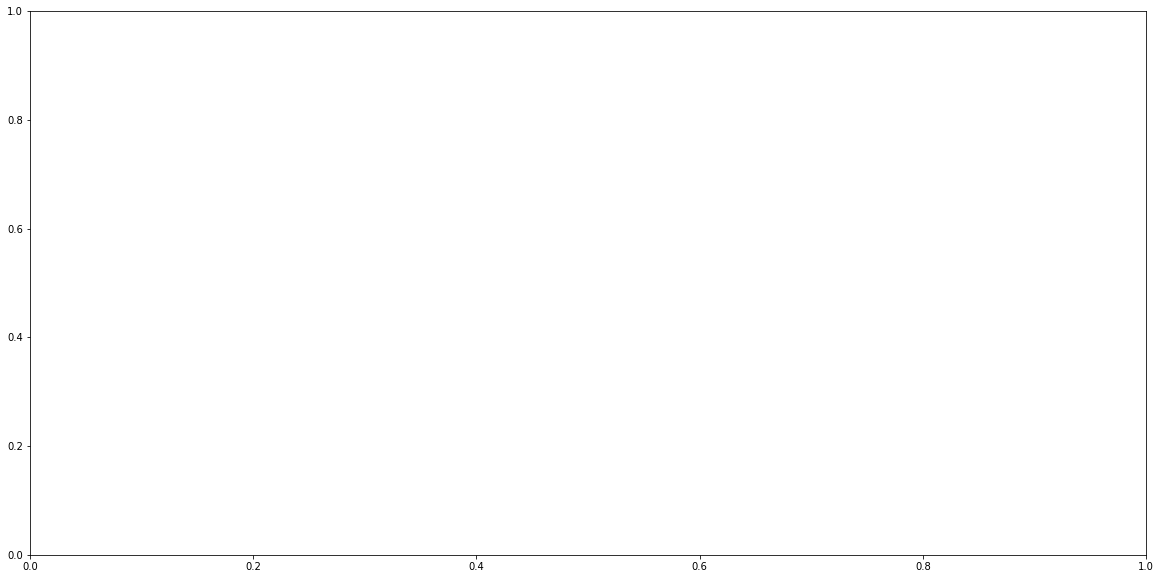

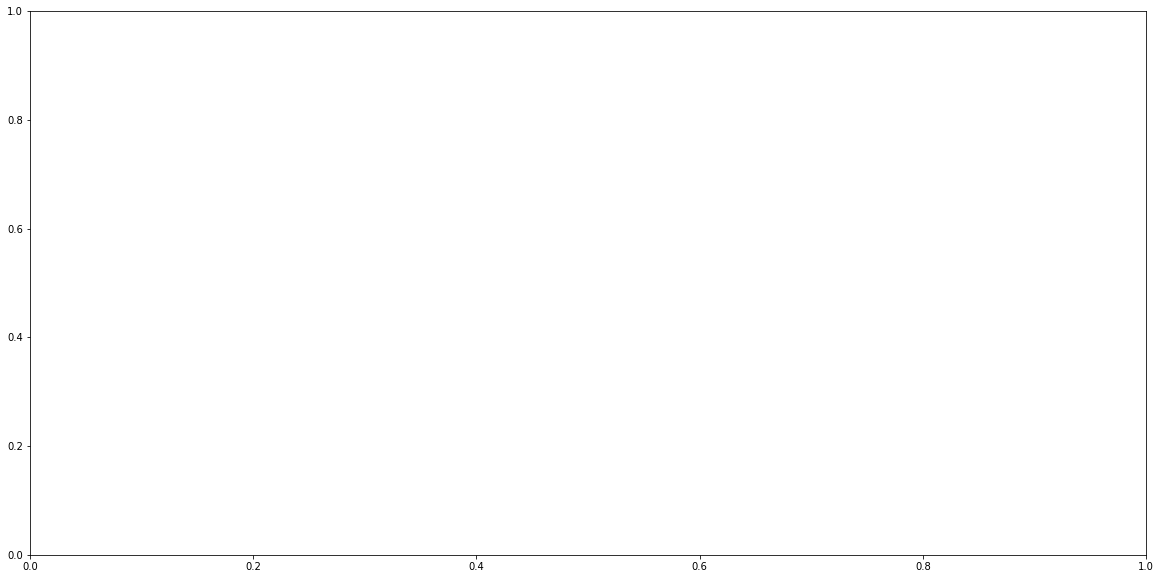

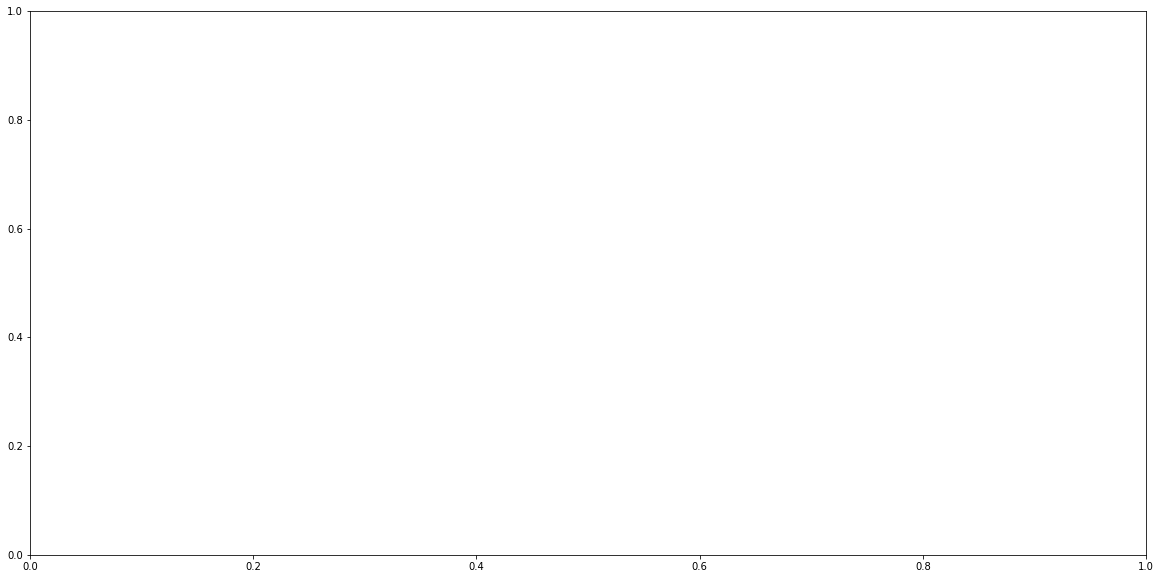

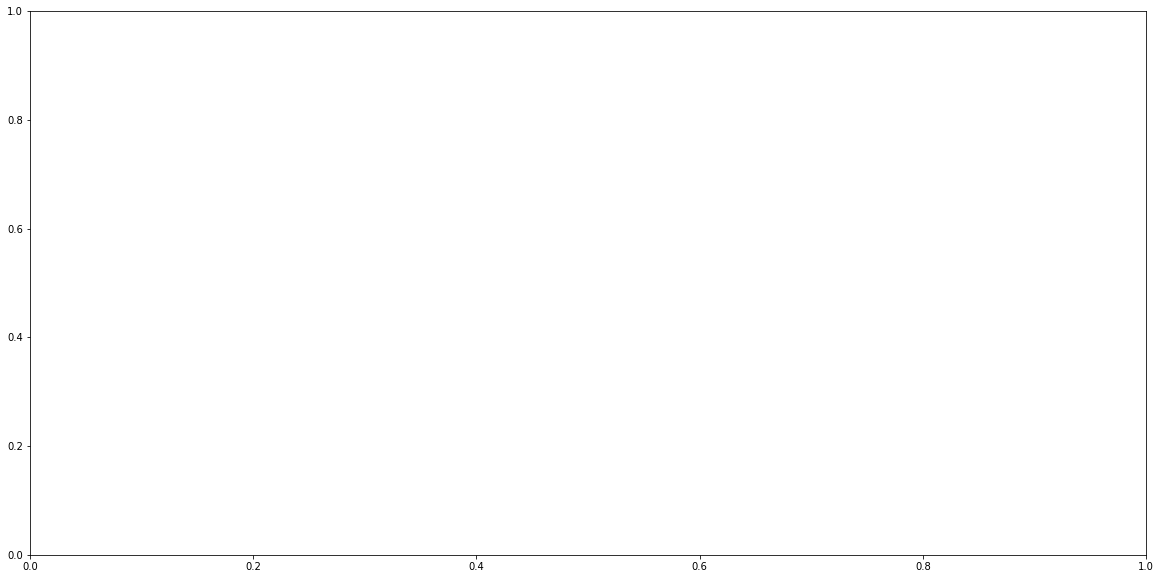

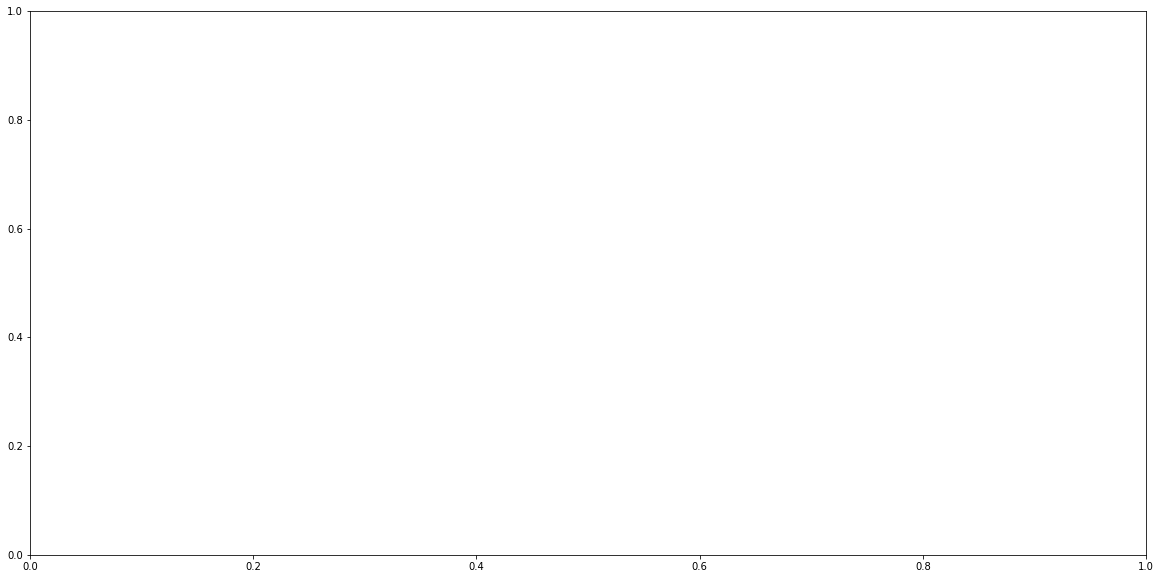

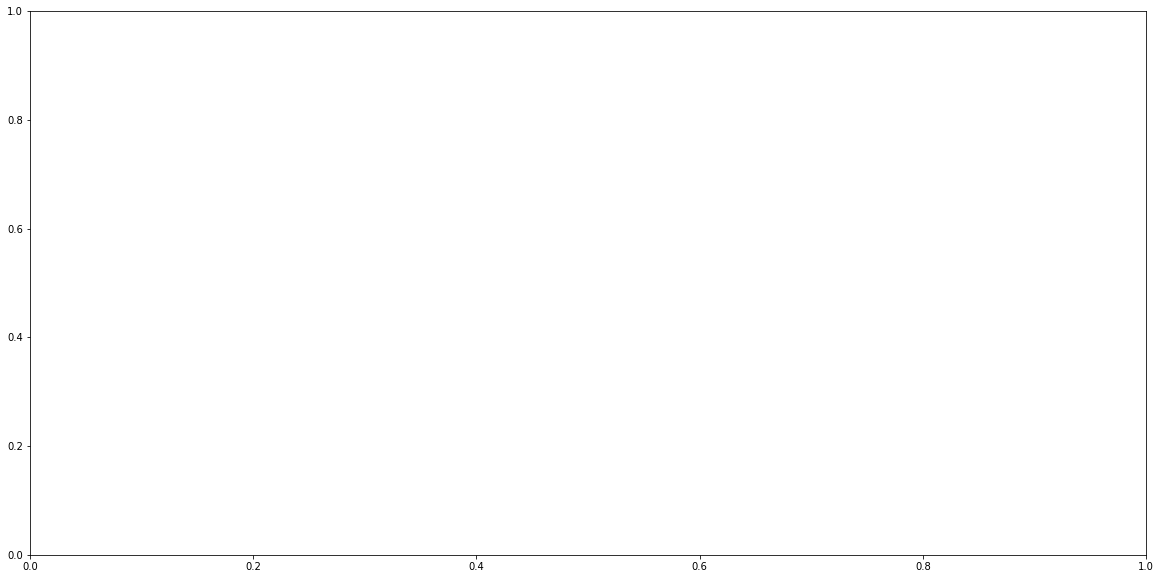

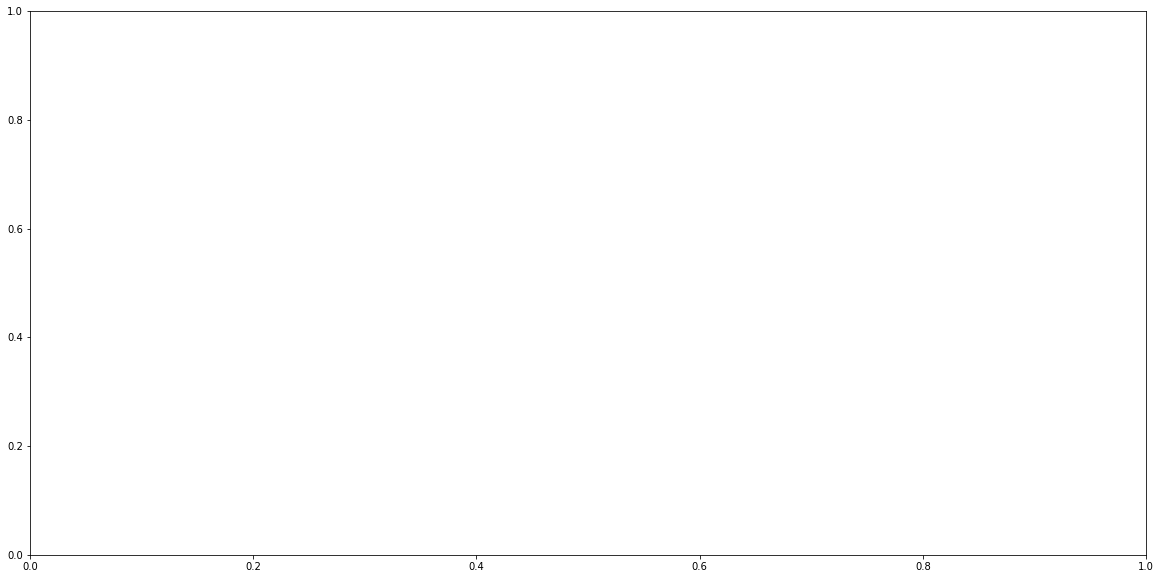

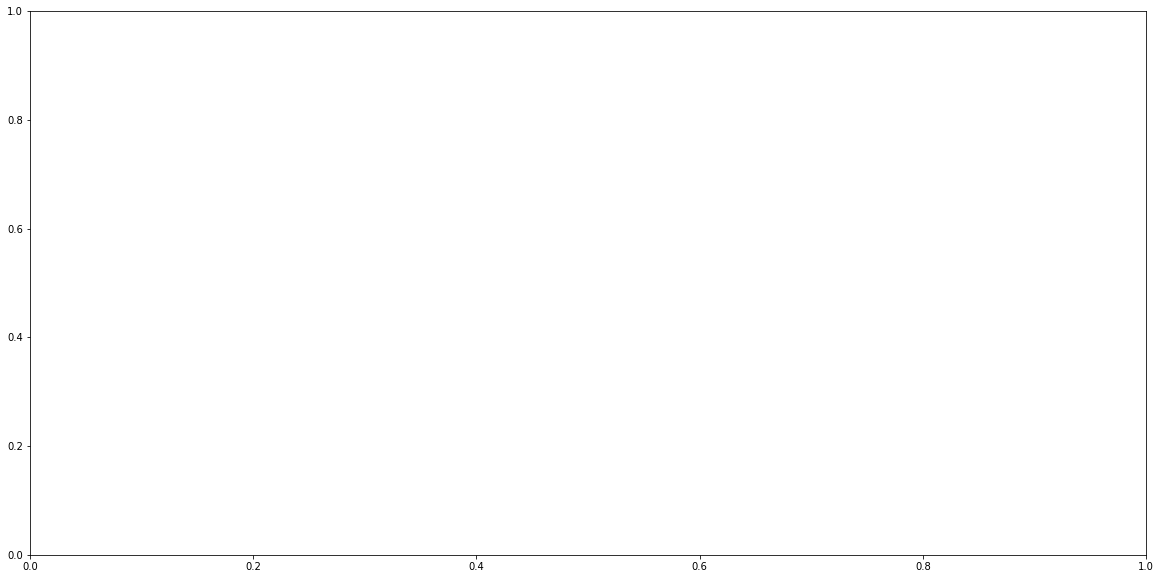

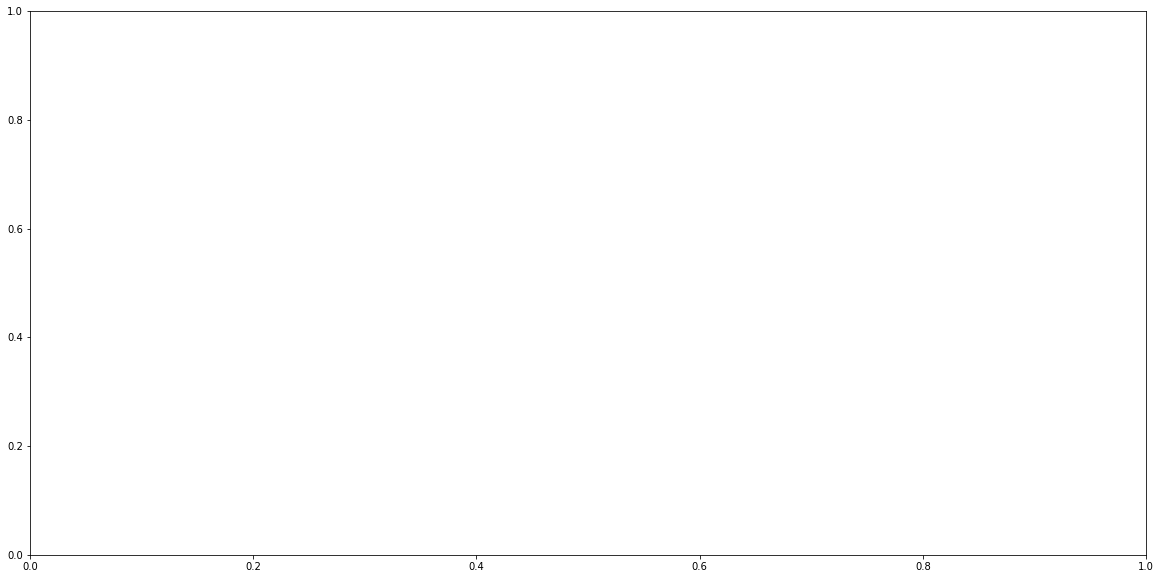

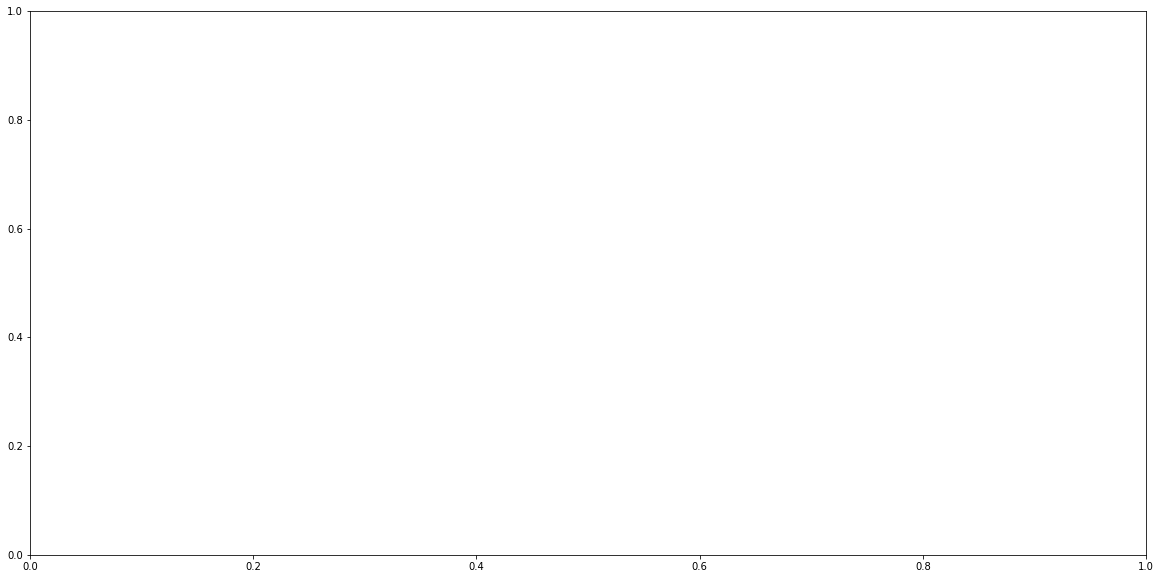

In [ ]:
"""
Generate animation frames
"""

dir = './frames'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

plt.figure(figsize=(20,10))
ax = plt.axes()

for l, result in enumerate(results):
    param_hist = result['sln_path']
    idx = np.linspace(0, len(param_hist)-1, num=100,dtype=int)
    #P_x, P_y = result['P']
    P_tmp = result['P']
    P_x_tmp = P_tmp
    P_y_tmp = P_tmp
    n0_x_tmp, n0_y_tmp = result['n']
    for k in idx:
        X_k_tmp = param_hist[k]

        X_k_n_tmp = np.zeros((n0_x_tmp.shape[0],2))
        X_k_n_tmp[:,0] = np.array(P_x_tmp.T@X_k_tmp[:,0]) + n0_x_tmp.T
        X_k_n_tmp[:,1] = np.array(P_y_tmp.T@X_k_tmp[:,1]) + n0_y_tmp.T
        positions_tmp = X_k_n_tmp

        ax.clear()
        
        ax = utils.plot_graph(X_k_n_tmp, graph, c=voxel_id)
        
        plt.savefig('./frames/{}_{}.png'.format(l, k))
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
"""
save animation as gif
"""
# filepaths
fp_in = "./frames/*.png"
fp_out = "./frames/animation.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in),key=os.path.getmtime)]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)

In [ ]:
_, unique_vidx = np.unique(voxel_id, return_index=True)
X_k = X_k_n
#opt_init, opt_update, get_params = padam(1e-1,partial(lambda x, y: project(y,x),C), b1=0.9, b2=0.999, eps=1e-08)
#opt_init, opt_update, get_params = padam(1e-1,lambda x: x, b1=0.9, b2=0.999, eps=1e-08)

for vidx in unique_vidx:
    vid = voxel_id[vidx]
    fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)
    #if (1-fixed_indices).sum() < 100:
    #    continue
    
    num_move = (1-fixed_indices).sum()
    cc1 = num_move*size[0]**2*1/12
    cc2 = num_move*size[1]**2*1/12
    cc3 = 0
    
    C = jnp.block([[cc1, cc3],[cc3, cc2]])
        
    offset = (np.max(positions,axis=0) - np.min(positions,axis=0))/2
    centroid = voxel2bound[vidx]*size + size/2 - offset
    
    #opt_init, opt_update, get_params = padam(1e-4,partial(lambda x, y, z: project(z, x, y), C, centroid), 
    #                                         b1=0.9, b2=0.999, eps=1e-08)
    #opt_init, opt_update, get_params = padam(1e-2,lambda x : x, 
    #                                         b1=0.9, b2=0.999, eps=1e-08)
    opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))


    result = cluster(rng, (opt_init, opt_update, get_params), 
                     X_k, L, np.where(fixed_indices)[0], maxiters=5000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                     centercons=num_move*centroid, v=None, D=None, eps=1e-8)
    results.append(result)
    X_k = result['x']
    gc = result['g']
    hc = result['h']
    loss = result['lossh']
    #param_hist.extend(result['sln_path'])
    print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))    

In [ ]:
"""BFS"""

def BFS(i, maxdepth, X_k, results):
    if i > maxdepth:
        return results
    size = np.array([10, 10])
    voxel_id, voxel2bound = voxel_cluster(X_k_n, size)
    _, unique_vidx = np.unique(voxel_id, return_index=True)
    
    for vidx in unique_vidx:
        vid = voxel_id[vidx]
        fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)

        num_move = (1-fixed_indices).sum()
        cc1 = num_move*size[0]**2*1/12
        cc2 = num_move*size[1]**2*1/12
        cc3 = 0

        C = jnp.block([[cc1, cc3],[cc3, cc2]])

        offset = (np.max(positions,axis=0) - np.min(positions,axis=0))/2
        centroid = voxel2bound[vidx]*size + size/2 - offset

        result = cluster(rng, (opt_init, opt_update, get_params), 
                     X_k, L, np.where(fixed_indices)[0], maxiters=5000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                     centercons=num_move*centroid, v=None, D=None, eps=1e-8)

        results.append(result)
        X_k = result['x']
        gc = result['g']
        hc = result['h']
        loss = result['lossh']

        print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))

        DFS(i+1, maxdepth, X_k, results)